# EBM Training on Google Colab Pro+ (A100)

This notebook trains an Energy-Based Model (EBM) to learn the energy landscape of UC/DR/Storage binary variables from MILP solutions, conditioned on Hierarchical Temporal Encoder embeddings.

## Hardware Requirements
- **GPU**: A100 (40 or 80 GB VRAM)
- **RAM**: 50+ GB (High RAM runtime)
- **Storage**: 100+ GB on Drive

## Setup
1. Upload your `benchmark` repo to Google Drive
2. Select Runtime → Change runtime type → A100 GPU + High RAM
3. Run cells in order

---

## 1. Mount Google Drive and Setup Paths

In [2]:
# Mount Google Drive
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# Set paths - ADJUST THIS to match your Drive structure
REPO_PATH = '/content/drive/MyDrive/benchmark'
EMBEDDING_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt'
EMBEDDING_ZONE_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_zone.pt'
SCENARIOS_DIR = 'outputs/scenarios_v1_filtered'
SCENARIO_DIR_EVAL = 'outputs/scenarios_v1/eval'
OUTPUT_DIR = 'outputs/ebm_models'

# Add repo to Python path
sys.path.insert(0, REPO_PATH)

# Verify paths exist
print(f"Repo path: {REPO_PATH}")
print(f"Repo exists: {os.path.exists(REPO_PATH)}")
print(f"Embeddings path: {os.path.join(REPO_PATH, EMBEDDING_FILE)}")
print(f"Embeddings exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_FILE))}")
print(f"Embeddings zone exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_ZONE_FILE))}")
print(f"Scenarios exist: {os.path.exists(os.path.join(REPO_PATH, SCENARIOS_DIR))}")
print(f"Scenario EVAL: {os.path.exists(os.path.join(REPO_PATH, SCENARIO_DIR_EVAL))}")

Mounted at /content/drive
Repo path: /content/drive/MyDrive/benchmark
Repo exists: True
Embeddings path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt
Embeddings exist: True
Embeddings zone exist: True
Scenarios exist: True
Scenario EVAL: True


## 2. Install Dependencies

In [2]:
# Install required packages
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install -q wandb tqdm pandas numpy scipy

import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q wandb numpy scipy tqdm pandas thrml

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 

## 3. Check GPU and System Info

In [3]:
import torch
import subprocess

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)

# GPU Info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

    # Verify it's A100
    if 'A100' in gpu_name:
        print("✓ A100 GPU detected!")
    else:
        print(f"⚠️  Warning: Expected A100, got {gpu_name}")
        print("   Change runtime: Runtime → Change runtime type → A100")
else:
    print("❌ No GPU detected!")
    print("   Enable GPU: Runtime → Change runtime type → GPU")

# RAM Info
try:
    mem_info = !cat /proc/meminfo | grep MemTotal
    mem_gb = int(mem_info[0].split()[1]) / 1e6
    print(f"\nRAM: {mem_gb:.1f} GB")
    if mem_gb > 45:
        print("✓ High RAM runtime detected!")
    else:
        print("⚠️  Consider using High RAM runtime for better performance")
except:
    print("\nCouldn't detect RAM")

# Disk Space
disk_info = !df -h /content
print(f"\nDisk Space:\n{disk_info[1]}")

print("=" * 60)

SYSTEM INFORMATION
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB
CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
✓ A100 GPU detected!

RAM: 175.2 GB
✓ High RAM runtime detected!

Disk Space:
overlay         236G   52G  185G  22% /


## 4. Import EBM Modules

In [4]:
import os

os.chdir(REPO_PATH)

from torch.utils.data import DataLoader, random_split, Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_add_pool
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime

from src.ebm import (
    EnergyModel,
    StructuredEnergyModel,
    GibbsSampler,
    SGLDSampler,
    # PersistentContrastiveDivergence, # Removed due to ImportError
    MILPBinaryDataset,
    EBMTrainer,
    # ScheduledEBMTrainer,
    EBMMetrics,
    # TemporalMetrics,
    EmbeddingLoader,
    # collate_ebm_batch,
)

from src.ebm.model import GraphEnergyModel
from src.ebm.sampler import PersistentContrastiveDivergence, GraphSampler
from src.ebm.dataset import collate_ebm_batch, GraphBinaryDataset
from src.ebm.trainer import EBMTrainer, ScheduledEBMTrainer
from src.ebm.metrics import TemporalMetrics

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 5. Configuration

In [5]:
# Training Configuration
import shutil

# Define paths
drive_embedding_path = os.path.join(REPO_PATH, EMBEDDING_ZONE_FILE)
local_embedding_path = '/content/embeddings_zone_level.pt'

# Copy file if not present locally
if not os.path.exists(local_embedding_path):
    print(f"🔄 Copying embeddings to local disk for faster I/O...")
    print(f"   Source: {drive_embedding_path}")
    print(f"   Dest:   {local_embedding_path}")
    print("   ⏳ This may take 1 minutes...")
    shutil.copy(drive_embedding_path, local_embedding_path)
    print("   ✓ Copy complete!")
else:
    print(f"✓ Embeddings already found locally: {local_embedding_path}")

CONFIG = {
    # Data
    'scenarios_dir': os.path.join(REPO_PATH, SCENARIOS_DIR),
    'scenarios_dir_eval': os.path.join(REPO_PATH, SCENARIO_DIR_EVAL),
    'embedding_file': local_embedding_path, # Updated to local path
    'output_dir': os.path.join(REPO_PATH, OUTPUT_DIR),

    # Model
    'model_type': 'structured',  # 'basic', 'structured', or 'factorized'
    'hidden_dims': [256, 256, 64],
    'use_quadratic': True,
    'quadratic_rank': 16,
    'activation': 'gelu',
    'dropout': 0.1,

    # Data loading
    'embedding_loading_mode': 'full',  # 'full' or 'lazy' - use full on A100!
    'temporal': False,  # Set True for temporal EBM
    'temporal_aggregation': 'mean',  # 'mean', 'max', 'last', 'first'

    # Training
    'batch_size': 128,  # Large batches for A100
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'gradient_clip': 1.0,

    # Sampling
    'sampler_type': 'pcd',  # 'gibbs', 'sgld', or 'pcd'
    'num_gibbs_steps': 5,  # Reduced from 50 to 5 for PCD (10x speedup)
    'temperature': 1.0,
    'initial_temperature': 2.0,
    'final_temperature': 1.0,
    'use_pcd': True,
    'num_pcd_chains': 128, # Reduced from 2000 to 128 to fix latency bottleneck

    # Training dynamics
    'num_negative_samples': 1,
    'use_amp': True,  # Mixed precision for A100
    'num_workers': 0,  # Parallel data loading

    # Evaluation
    'validate_every': 5,
    'save_every': 10,

    # Logging
    'use_wandb': False,  # Set True to log to W&B
    'wandb_project': 'milp-ebm',
    'wandb_name': f'ebm_a100_{datetime.now().strftime("%Y%m%d_%H%M%S")}',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

# Set random seed
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Print configuration
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for key, value in CONFIG.items():
    if not key.startswith('_'):
        print(f"{key:25s}: {value}")
print("=" * 60 + "\n")

✓ Embeddings already found locally: /content/embeddings_zone_level.pt

TRAINING CONFIGURATION
scenarios_dir            : /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered
scenarios_dir_eval       : /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
embedding_file           : /content/embeddings_zone_level.pt
output_dir               : /content/drive/MyDrive/benchmark/outputs/ebm_models
model_type               : structured
hidden_dims              : [256, 256, 64]
use_quadratic            : True
quadratic_rank           : 16
activation               : gelu
dropout                  : 0.1
embedding_loading_mode   : full
temporal                 : False
temporal_aggregation     : mean
batch_size               : 128
num_epochs               : 100
learning_rate            : 0.0001
weight_decay             : 1e-05
gradient_clip            : 1.0
sampler_type             : pcd
num_gibbs_steps          : 5
temperature              : 1.0
initial_temperature      : 2.0
final_

## 6. Load Dataset with Full Embeddings

In [6]:
import torch
import numpy as np
import json
import os
from pathlib import Path

# Config
REPO_PATH = Path('/content/drive/MyDrive/benchmark')
EMBEDDING_PATH = Path('/content/embeddings_multiscale_normalized.pt')
OUTPUT_PATH = Path('/content/embeddings_zone_level.pt')
DATASET_INDEX = REPO_PATH / 'outputs/graphs/hetero_temporal_v1/dataset_index.json'

# Check if output already exists
if OUTPUT_PATH.exists():
    print(f"✅ Zone embeddings already exist at {OUTPUT_PATH}")
    print("   Skipping reformatting...")
else:
    print("🔧 Reformatting ZONE-LEVEL embeddings for EBM (variable zones)...")

    # 1. Load raw embeddings
    print(f"📂 Loading raw embeddings from {EMBEDDING_PATH}...")
    raw_data = torch.load(EMBEDDING_PATH, map_location='cpu', weights_only=False)
    all_embeddings = raw_data['embeddings']

    # 2. Load dataset index - extract zone counts per scenario
    print(f"📖 Loading dataset index from {DATASET_INDEX}...")
    with open(DATASET_INDEX, 'r') as f:
        index_data = json.load(f)

    scenario_ids = []
    zone_counts = []

    for entry in index_data['entries']:
        fname = os.path.basename(entry['graph_file'])
        scenario_ids.append(fname)

        # Normalize path separators
        graph_file = entry['graph_file'].replace('\\', '/')
        graph_path = REPO_PATH / graph_file

        # Load .npz file with numpy
        graph_data = np.load(graph_path, allow_pickle=True)

        # Zone count = length of zone_region_index (maps each zone to its region)
        n_zones = len(graph_data['zone_region_index'])
        zone_counts.append(n_zones)

    print(f"   Found {len(scenario_ids)} scenario IDs.")
    print(f"   Zone counts - min: {min(zone_counts)}, max: {max(zone_counts)}, total: {sum(zone_counts)}")

    # 3. Extract ZONE level embeddings
    LEVEL_TO_USE = 'zones'
    print(f"⚙️ Extracting level: '{LEVEL_TO_USE}'...")

    emb_list = all_embeddings[LEVEL_TO_USE]

    # 4. Concatenate batches
    print("   Concatenating batches...")
    if isinstance(emb_list, list):
        full_tensor = torch.cat(emb_list, dim=0)
    else:
        full_tensor = emb_list

    print(f"   Raw Zone Tensor Shape: {full_tensor.shape}")
    T = full_tensor.shape[1]
    D = full_tensor.shape[2]

    # Verify total matches
    assert sum(zone_counts) == full_tensor.shape[0], \
        f"Mismatch: sum(zone_counts)={sum(zone_counts)} vs tensor[0]={full_tensor.shape[0]}"

    # 5. Build dictionary with variable zones per scenario
    print("📚 Building zone-level scenario dictionary (variable zones)...")
    formatted_dict = {}
    current_idx = 0

    for i, sc_id in enumerate(scenario_ids):
        n_zones = zone_counts[i]
        sc_tensor = full_tensor[current_idx : current_idx + n_zones].clone()
        current_idx += n_zones

        clean_id = os.path.splitext(os.path.basename(sc_id.replace('\\', '/')))[0]
        formatted_dict[clean_id] = sc_tensor

    # 6. Save
    print(f"💾 Saving zone-level embeddings to {OUTPUT_PATH}...")
    torch.save(formatted_dict, OUTPUT_PATH)

    print(f"✅ Done! Zone embeddings ready.")
    print(f"   Scenarios: {len(formatted_dict)}")
    print(f"   Example shapes: {[formatted_dict[k].shape for k in list(formatted_dict.keys())[:3]]}")

✅ Zone embeddings already exist at /content/embeddings_zone_level.pt
   Skipping reformatting...


In [7]:
# Cell 13: Zone-to-Variable Mapping Builder (per-scenario)

import pandas as pd
import os
import torch
from pathlib import Path
from tqdm import tqdm

def build_zone_variable_mapping(dispatch_file):
    """
    Build mapping for a SINGLE scenario: variable indices -> (zone, timestep).
    Must be called per-scenario since zone counts vary.

    Returns:
        zone_map: dict {(zone_idx, t): list of variable indices}
        zone_list: list of unique zone names in order
        n_features: number of binary features per (zone, time)
        n_timesteps: number of timesteps
    """
    df = pd.read_csv(dispatch_file)
    df = df.sort_values(by=['time_step', 'zone']).reset_index(drop=True)

    zone_list = sorted(df['zone'].unique().tolist())
    zone_to_idx = {z: i for i, z in enumerate(zone_list)}

    # Decision variables only - excludes state vars to prevent data leakage
    target_cols = [
        'battery_charge',      # 0 → battery_charge_mode
        'battery_discharge',   # 1 (info seulement)
        'pumped_charge',       # 2 → pumped_charge_mode
        'pumped_discharge',    # 3 (info seulement)
        'demand_response',     # 4 → dr_active
        'nuclear',             # 5 → u_nuclear
        'thermal',             # 6 → u_thermal
    ]
    cols_to_use = [c for c in target_cols if c in df.columns]
    n_features = len(cols_to_use)

    n_timesteps = df['time_step'].nunique()
    n_zones = len(zone_list)

    zone_map = {}
    var_idx = 0

    for t in range(n_timesteps):
        for z_idx, zone in enumerate(zone_list):
            zone_map[(z_idx, t)] = list(range(var_idx, var_idx + n_features))
            var_idx += n_features

    return zone_map, zone_list, n_features, n_timesteps


def get_scenario_zone_mapping(scenario_id, scenarios_dir):
    """Get zone mapping for a specific scenario."""
    dispatch_file = os.path.join(scenarios_dir, 'dispatch_batch', f'{scenario_id}_zone.csv')
    if not os.path.exists(dispatch_file):
        dispatch_file = os.path.join(scenarios_dir, f'{scenario_id}_zone.csv')
    return build_zone_variable_mapping(dispatch_file)


# Output path
EMBEDDING_ZONE_MAPPING_FILE = Path('/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_zone_mapping.pt')

# Check if already exists
if EMBEDDING_ZONE_MAPPING_FILE.exists():
    print(f"✅ Zone mappings already exist at {EMBEDDING_ZONE_MAPPING_FILE}")
    print("   Loading from file...")
    saved_data = torch.load(EMBEDDING_ZONE_MAPPING_FILE, map_location='cpu', weights_only=False)
    SCENARIO_ZONE_MAPPINGS = saved_data['mappings']
    N_FEATURES_PER_ZT = saved_data['n_features']
    N_TIMESTEPS = saved_data['n_timesteps']
    zone_counts = [m['n_zones'] for m in SCENARIO_ZONE_MAPPINGS.values()]
    print(f"   Loaded {len(SCENARIO_ZONE_MAPPINGS)} scenario mappings")
else:
    print("📊 Building zone mappings for all scenarios...")

    # Get list of all scenario IDs from embeddings
    zone_embeddings = torch.load(CONFIG['embedding_file'], map_location='cpu', weights_only=False)
    scenario_ids = list(zone_embeddings.keys())

    SCENARIO_ZONE_MAPPINGS = {}
    zone_counts = []
    feature_counts = set()

    for sc_id in tqdm(scenario_ids, desc="Building zone maps"):
        try:
            zone_map, zone_list, n_feat, n_time = get_scenario_zone_mapping(sc_id, CONFIG['scenarios_dir'])
            SCENARIO_ZONE_MAPPINGS[sc_id] = {
                'zone_map': zone_map,
                'zone_list': zone_list,
                'n_zones': len(zone_list),
                'n_features': n_feat,
                'n_timesteps': n_time
            }
            zone_counts.append(len(zone_list))
            feature_counts.add(n_feat)
        except FileNotFoundError:
            pass

    # Store feature config (derived from actual data)
    N_FEATURES_PER_ZT = list(feature_counts)[0] if len(feature_counts) == 1 else max(feature_counts)
    N_TIMESTEPS = 24

    # Save to Drive
    print(f"\n💾 Saving zone mappings to {EMBEDDING_ZONE_MAPPING_FILE}...")
    EMBEDDING_ZONE_MAPPING_FILE.parent.mkdir(parents=True, exist_ok=True)
    torch.save({
        'mappings': SCENARIO_ZONE_MAPPINGS,
        'n_features': N_FEATURES_PER_ZT,
        'n_timesteps': N_TIMESTEPS,
        'target_cols': [
            'battery_charge',      # 0 → battery_charge_mode
            'battery_discharge',   # 1 (info seulement)
            'pumped_charge',       # 2 → pumped_charge_mode
            'pumped_discharge',    # 3 (info seulement)
            'demand_response',     # 4 → dr_active
            'nuclear',             # 5 → u_nuclear
            'thermal',             # 6 → u_thermal
          ]
    }, EMBEDDING_ZONE_MAPPING_FILE)
    print("   ✅ Saved!")

print(f"\n✅ Zone mappings ready: {len(SCENARIO_ZONE_MAPPINGS)} scenarios")
print(f"   Zone counts - min: {min(zone_counts)}, max: {max(zone_counts)}, mean: {sum(zone_counts)/len(zone_counts):.1f}")
print(f"   N_FEATURES_PER_ZT = {N_FEATURES_PER_ZT}")
print(f"   N_TIMESTEPS = {N_TIMESTEPS}")

✅ Zone mappings already exist at /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_zone_mapping.pt
   Loading from file...
   Loaded 2960 scenario mappings

✅ Zone mappings ready: 2960 scenarios
   Zone counts - min: 4, max: 127, mean: 55.4
   N_FEATURES_PER_ZT = 7
   N_TIMESTEPS = 24


In [8]:
# Update CONFIG to use zone-level embeddings
CONFIG['embedding_file'] = '/content/embeddings_zone_level.pt'
CONFIG['embedding_type'] = 'zone'  # Mark as zone-level

# Store zone config in CONFIG for easy access
# Note: n_zones varies per scenario, so we store min/max/mean
CONFIG['n_zones_min'] = min(zone_counts)
CONFIG['n_zones_max'] = max(zone_counts)
CONFIG['n_zones_mean'] = sum(zone_counts) / len(zone_counts)
CONFIG['n_timesteps'] = N_TIMESTEPS
CONFIG['n_features_per_zt'] = N_FEATURES_PER_ZT

# Get embed_dim from the loaded embeddings
zone_embeddings = torch.load(CONFIG['embedding_file'], map_location='cpu', weights_only=False)
sample_emb = list(zone_embeddings.values())[0]
CONFIG['embed_dim'] = sample_emb.shape[-1]  # Last dim is embedding dimension

print(f"✓ CONFIG updated for zone-level EBM:")
print(f"  embedding_file: {CONFIG['embedding_file']}")
print(f"  n_zones: {CONFIG['n_zones_min']}-{CONFIG['n_zones_max']} (varies per scenario)")
print(f"  n_features_per_zt: {CONFIG['n_features_per_zt']}")
print(f"  embed_dim: {CONFIG['embed_dim']}")

✓ CONFIG updated for zone-level EBM:
  embedding_file: /content/embeddings_zone_level.pt
  n_zones: 4-127 (varies per scenario)
  n_features_per_zt: 7
  embed_dim: 128


In [9]:
# Clear RAM
import gc
gc.collect()

print("Loading dataset...")
print(f"Embedding loading mode: {CONFIG['embedding_loading_mode']}")
print("⏳ This may take a few minutes for full loading...\n")

dataset = MILPBinaryDataset(
    scenarios_dir=CONFIG['scenarios_dir'],
    embedding_file=CONFIG['embedding_file'],
    embedding_loading_mode=CONFIG['embedding_loading_mode'],
    temporal=CONFIG['temporal'],
    temporal_aggregation=CONFIG['temporal_aggregation'],
    device='cpu',
)

# --- FILTER DATASET TO MATCH EMBEDDINGS ---
# Load zone embeddings to get valid keys
zone_emb_keys = set(zone_embeddings.keys())
print(f"\n🔍 Found {len(zone_emb_keys)} embeddings in file.")

if len(zone_emb_keys) > 0 and len(zone_emb_keys) < len(dataset):
    print(f"⚠️ Dataset has {len(dataset)} scenarios, but only {len(zone_emb_keys)} embeddings found.")
    print("🧹 Filtering dataset to match available embeddings...")

    # Filter scenarios
    valid_scenario_ids = []
    for s in dataset.scenario_ids:
        key = os.path.splitext(s)[0]
        if key in zone_emb_keys or s in zone_emb_keys:
            valid_scenario_ids.append(s)

    dataset.scenario_ids = valid_scenario_ids
    print(f"✓ Filtered down to {len(dataset)} scenarios.")
elif len(zone_emb_keys) == 0:
    print("❌ No embeddings found! Check the file.")
else:
    print("✓ All scenarios have embeddings.")
# ------------------------------------------

print(f"\n✓ Dataset loaded: {len(dataset)} scenarios")

if len(dataset) > 0:
    sample = dataset[0]

    # Binary variables
    dim_u = sample['u'].numel()
    print(f"Binary variables (dim_u): {dim_u}")
    print(f"Binary vars shape: {sample['u'].shape}")

    # Embedding - zone-level is [n_zones, T, D] or flattened
    h_shape = sample['h'].shape
    print(f"Embedding shape: {h_shape}")
    if len(h_shape) == 1:
        dim_h = h_shape[0]
    elif len(h_shape) == 2:
        dim_h = h_shape[-1]  # [T, D] or [n_zones*T, D]
    else:
        dim_h = h_shape[-1]  # [n_zones, T, D]
    print(f"Embedding dimension (dim_h): {dim_h}")

    print(f"Sample scenario: {sample['scenario_id']}")

    # Check if embeddings are real
    h_mean = sample['h'].mean().item()
    h_std = sample['h'].std().item()
    print(f"\nEmbedding stats: mean={h_mean:.4f}, std={h_std:.4f}")
    if abs(h_mean) < 0.01 and h_std < 0.01:
        print("⚠️  Warning: Embeddings might be zeros!")
    else:
        print("✓ Real embeddings detected")
else:
    print("❌ Dataset is empty after filtering!")

Loading dataset...
Embedding loading mode: full
⏳ This may take a few minutes for full loading...


Initializing embedding loader from: /content/embeddings_zone_level.pt
Found embeddings at: /content/embeddings_zone_level.pt
Initializing EmbeddingLoader for /content/embeddings_zone_level.pt
File size: 2.02 GB
Loading mode: full
Loading full embeddings file (this may take a while)...


/content/drive/MyDrive/benchmark/src/ebm/embedding_loader.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.embedding_file, map_location=self.devic

Loaded direct mapping with 2960 scenarios
Sample embedding shape: torch.Size([52, 24, 128])
Sample embedding dtype: torch.float32
Total scenarios: 2960
Embeddings already on CPU
Loaded 2960 scenarios from /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered/dispatch_batch
Binary variables per scenario (est): 12480

🔍 Found 2960 embeddings in file.
✓ All scenarios have embeddings.

✓ Dataset loaded: 2960 scenarios
Binary variables (dim_u): 12480
Binary vars shape: torch.Size([12480])
Embedding shape: torch.Size([52, 24, 128])
Embedding dimension (dim_h): 128
Sample scenario: scenario_00001

Embedding stats: mean=0.4427, std=2.4932
✓ Real embeddings detected


In [10]:
# ==============================================================================
# TEMPORAL DYNAMICS INJECTION - Improvement #2 from Roadmap
# ==============================================================================
# This implements energy over zone temporal trajectories using GRU
# E = Σ_z E_θ(u_{z,1:T}, h_{z,1:T})
# ==============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, Batch
from torch_geometric.utils import scatter
from typing import Dict, List, Optional

print("📦 Implementing Temporal Dynamics Components...")

# ==============================================================================
# 1. TEMPORAL ZONAL DATASET
# ==============================================================================

class TemporalZonalDataset(Dataset):
    """
    Dataset that exposes temporal structure for zone-level EBM.

    Returns data with shape:
        u_zt: [Z, T, F] - binary decisions per (zone, time, feature)
        h_zt: [Z, T, D] - embeddings per (zone, time)

    This allows the model to learn intertemporal dependencies.
    """
    def __init__(self, base_dataset, zone_embeddings, scenario_zone_mappings, embed_dim, n_features):
        """
        Args:
            base_dataset: MILPBinaryDataset instance
            zone_embeddings: dict {scenario_id: tensor [Z, T, D]}
            scenario_zone_mappings: dict {scenario_id: {zone_map, n_zones, n_features, ...}}
            embed_dim: embedding dimension D
            n_features: number of binary features per (zone, time) F
        """
        self.base_dataset = base_dataset
        self.zone_embeddings = zone_embeddings
        self.scenario_zone_mappings = scenario_zone_mappings
        self.embed_dim = embed_dim
        self.n_features = n_features

    def __len__(self):
        return len(self.base_dataset)

    def _get_scenario_key(self, scenario_id):
        """Find the matching key in embeddings/mappings."""
        if scenario_id in self.zone_embeddings:
            return scenario_id
        clean_id = scenario_id.replace('_zone', '')
        if clean_id in self.zone_embeddings:
            return clean_id
        raise KeyError(f"Scenario {scenario_id} not found in zone embeddings")

    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        scenario_id = sample['scenario_id']
        u_flat = sample['u']  # [N_vars] flattened binary variables

        # Get the correct key
        key = self._get_scenario_key(scenario_id)

        # Get zone embeddings: [Z, T, D]
        h_zt = self.zone_embeddings[key].clone()

        # Get per-scenario zone mapping
        if key not in self.scenario_zone_mappings:
            raise KeyError(f"No zone mapping for scenario {key}")

        mapping = self.scenario_zone_mappings[key]
        n_zones = mapping['n_zones']
        n_timesteps = mapping['n_timesteps']
        n_features = mapping['n_features']

        # Reshape flat binary vars to [Z, T, F]
        # The data is ordered as: for each t, for each z, features
        # So shape is [T * Z * F] -> [T, Z, F] -> [Z, T, F]
        try:
            u_temporal = u_flat.view(n_timesteps, n_zones, n_features)
            u_zt = u_temporal.permute(1, 0, 2).contiguous()  # [Z, T, F]
        except RuntimeError:
            # Fallback: pad/truncate if mismatch
            expected_size = n_timesteps * n_zones * n_features
            if u_flat.numel() < expected_size:
                u_padded = torch.zeros(expected_size)
                u_padded[:u_flat.numel()] = u_flat
                u_flat = u_padded
            else:
                u_flat = u_flat[:expected_size]
            u_temporal = u_flat.view(n_timesteps, n_zones, n_features)
            u_zt = u_temporal.permute(1, 0, 2).contiguous()

        # Ensure h_zt matches dimensions
        if h_zt.shape[0] != n_zones:
            # Pad or truncate zones in embeddings
            if h_zt.shape[0] < n_zones:
                pad_z = n_zones - h_zt.shape[0]
                h_zt = F.pad(h_zt, (0, 0, 0, 0, 0, pad_z))
            else:
                h_zt = h_zt[:n_zones]

        return {
            'u_zt': u_zt.float(),           # [Z, T, F]
            'h_zt': h_zt.float(),           # [Z, T, D]
            'n_zones': n_zones,
            'n_timesteps': n_timesteps,
            'n_features': n_features,
            'scenario_id': key,
        }


print("✅ TemporalZonalDataset defined")

📦 Implementing Temporal Dynamics Components...
✅ TemporalZonalDataset defined


In [11]:
# ==============================================================================
# 2. TEMPORAL COLLATE FUNCTION (FIXED)
# ==============================================================================

import torch
import torch.nn.functional as F_nn  # Renamed to avoid shadowing

def temporal_collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    """
    Collate function for variable-sized temporal zonal data.

    Pads zones to max in batch and creates masks.

    Args:
        batch: List of dicts from TemporalZonalDataset

    Returns:
        Dictionary with batched tensors:
            u_zt: [B, Z_max, T, F]
            h_zt: [B, Z_max, T, D]
            zone_mask: [B, Z_max] - 1 for valid zones, 0 for padding
            n_zones: [B] - original zone counts
    """
    # Find max zones in batch
    max_zones = max(d['n_zones'] for d in batch)
    n_timesteps = batch[0]['n_timesteps']
    n_features = batch[0]['n_features']
    embed_dim = batch[0]['h_zt'].shape[-1]

    u_batch = []
    h_batch = []
    zone_masks = []
    n_zones_list = []
    scenario_ids = []

    for d in batch:
        Z = d['n_zones']
        pad_z = max_zones - Z

        # Pad u_zt: [Z, T, F] -> [Z_max, T, F]
        u_padded = F_nn.pad(d['u_zt'], (0, 0, 0, 0, 0, pad_z))
        u_batch.append(u_padded)

        # Pad h_zt: [Z, T, D] -> [Z_max, T, D]
        h_padded = F_nn.pad(d['h_zt'], (0, 0, 0, 0, 0, pad_z))
        h_batch.append(h_padded)

        # Zone mask: [Z_max]
        mask = torch.cat([torch.ones(Z), torch.zeros(pad_z)])
        zone_masks.append(mask)

        n_zones_list.append(Z)
        scenario_ids.append(d['scenario_id'])

    return {
        'u_zt': torch.stack(u_batch),           # [B, Z_max, T, F]
        'h_zt': torch.stack(h_batch),           # [B, Z_max, T, D]
        'zone_mask': torch.stack(zone_masks),   # [B, Z_max]
        'n_zones': torch.tensor(n_zones_list),  # [B]
        'n_timesteps': n_timesteps,
        'n_features': n_features,
        'scenario_ids': scenario_ids,
    }


print("✅ temporal_collate_fn defined (fixed F_nn import)")

✅ temporal_collate_fn defined (fixed F_nn import)


In [12]:
# ==============================================================================
# 5. INITIALIZE TEMPORAL COMPONENTS
# ==============================================================================

print("🔧 Creating Temporal Zonal Dataset...")

# Create temporal dataset
temporal_dataset = TemporalZonalDataset(
    base_dataset=dataset,
    zone_embeddings=zone_embeddings,
    scenario_zone_mappings=SCENARIO_ZONE_MAPPINGS,
    embed_dim=CONFIG['embed_dim'],
    n_features=N_FEATURES_PER_ZT,
)

print(f"✓ Dataset created: {len(temporal_dataset)} samples")

# Verify first sample
sample0 = temporal_dataset[0]
print(f"\nFirst sample verification:")
print(f"  u_zt shape: {sample0['u_zt'].shape} (expected: [Z, T, F])")
print(f"  h_zt shape: {sample0['h_zt'].shape} (expected: [Z, T, D])")
print(f"  n_zones: {sample0['n_zones']}")
print(f"  n_timesteps: {sample0['n_timesteps']}")
print(f"  n_features: {sample0['n_features']}")
print(f"  scenario_id: {sample0['scenario_id']}")

# Check a few more samples to verify variable zone handling
print("\nVariable zone verification:")
for i in [0, 100, 500]:
    if i < len(temporal_dataset):
        s = temporal_dataset[i]
        print(f"  Sample {i}: u_zt={s['u_zt'].shape}, n_zones={s['n_zones']}")

🔧 Creating Temporal Zonal Dataset...
✓ Dataset created: 2960 samples

First sample verification:
  u_zt shape: torch.Size([52, 24, 7]) (expected: [Z, T, F])
  h_zt shape: torch.Size([52, 24, 128]) (expected: [Z, T, D])
  n_zones: 52
  n_timesteps: 24
  n_features: 7
  scenario_id: scenario_00001

Variable zone verification:
  Sample 0: u_zt=torch.Size([52, 24, 7]), n_zones=52
  Sample 100: u_zt=torch.Size([89, 24, 7]), n_zones=89
  Sample 500: u_zt=torch.Size([12, 24, 7]), n_zones=12


## 7. Create Train/Val Split and DataLoaders

In [13]:
# ==============================================================================
# 6. CREATE TRAIN/VAL SPLIT AND DATALOADERS
# ==============================================================================

from torch.utils.data import random_split, DataLoader

# Split dataset
train_size = int(0.8 * len(temporal_dataset))
val_size = len(temporal_dataset) - train_size
train_dataset, val_dataset = random_split(temporal_dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# DataLoader settings
num_workers = 0  # Safe for notebooks
pin_memory = torch.cuda.is_available()

# Create DataLoaders with temporal collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    collate_fn=temporal_collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    collate_fn=temporal_collate_fn,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verify batch structure
print("\n🧪 Testing batch structure, this may take 2 minutes...")
test_batch = next(iter(train_loader))
print(f"  u_zt: {test_batch['u_zt'].shape} (B, Z_max, T, F)")
print(f"  h_zt: {test_batch['h_zt'].shape} (B, Z_max, T, D)")
print(f"  zone_mask: {test_batch['zone_mask'].shape} (B, Z_max)")
print(f"  n_zones: {test_batch['n_zones'][:5]}... (original zone counts)")
print(f"  Valid zones in batch: {test_batch['zone_mask'].sum(dim=1)[:5].tolist()}")

print("\n✅ Temporal DataLoaders ready!")

Train samples: 2368
Val samples: 592
Train batches: 19
Val batches: 5

🧪 Testing batch structure, this may take 2 minutes...
  u_zt: torch.Size([128, 117, 24, 7]) (B, Z_max, T, F)
  h_zt: torch.Size([128, 117, 24, 128]) (B, Z_max, T, D)
  zone_mask: torch.Size([128, 117]) (B, Z_max)
  n_zones: tensor([ 16,  55, 117,  56,  69])... (original zone counts)
  Valid zones in batch: [16.0, 55.0, 117.0, 56.0, 69.0]

✅ Temporal DataLoaders ready!


## 8. Initialize Model

In [14]:
class TrajectoryZonalEBM(nn.Module):
    """
    Energy-Based Model with temporal trajectory processing per zone.
    Robust to NaNs and padded zones.
    """
    def __init__(
        self,
        embed_dim: int,
        n_features: int,
        hidden_dim: int = 128,
        gru_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.use_peak_term = True
        self.peak_tau = 0.5
        self.peak_weight = 0.3

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_features + embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
        )

        # Temporal GRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=gru_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if gru_layers > 1 else 0,
        )

        # Energy head
        gru_out_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.energy_head = nn.Sequential(
            nn.Linear(gru_out_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _masked_logsumexp(self, x: torch.Tensor, dim: int, mask: Optional[torch.Tensor], tau: float):
        if mask is None:
            return tau * torch.logsumexp(x / tau, dim=dim)

        # Safe handling for -inf
        neg_inf = torch.finfo(x.dtype).min
        x_masked = x.masked_fill(mask == 0, neg_inf)
        return tau * torch.logsumexp(x_masked / tau, dim=dim)

    def forward(
        self,
        u_zt: torch.Tensor,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:

        # 1. SANITIZE INPUTS: Prevent NaN propagation from data
        if torch.isnan(u_zt).any():
            u_zt = torch.nan_to_num(u_zt, nan=0.0)
        if torch.isnan(h_zt).any():
            h_zt = torch.nan_to_num(h_zt, nan=0.0)

        B, Z, T, F = u_zt.shape
        D = h_zt.shape[-1]

        # Concatenate and Reshape
        x = torch.cat([u_zt, h_zt], dim=-1) # [B, Z, T, F+D]
        x = x.view(B * Z, T, F + D)

        # Forward pass
        x = self.input_proj(x)
        gru_out, _ = self.gru(x)
        e_zt = self.energy_head(gru_out) # [B*Z, T, 1]
        e_zt = e_zt.view(B, Z, T)

        # -------------------------
        # Mean Energy Term
        # -------------------------
        if zone_mask is not None:
            m_e = zone_mask.view(B, Z, 1).float()
            denom = (m_e.sum(dim=1) * T).clamp_min(1.0)

            # Squeeze check: ensure denom is [B] or [B,1] compatible
            if denom.dim() == 1: denom = denom.unsqueeze(-1)

            E_mean = (e_zt * m_e).sum(dim=(1, 2)) / denom.squeeze()
        else:
            E_mean = e_zt.mean(dim=(1, 2))

        # -------------------------
        # Peak Energy Term
        # -------------------------
        if self.use_peak_term:
            tau = float(self.peak_tau)
            w = float(self.peak_weight)

            m = zone_mask.view(B, Z, 1).bool() if zone_mask is not None else None

            # This returns -inf for masked zones!
            peak_z = self._masked_logsumexp(e_zt, dim=2, mask=m, tau=tau) # [B, Z]

            if zone_mask is not None:
                mz = zone_mask.float()

                # CRITICAL FIX: Replace -inf with 0.0 before multiplying by 0.0 mask
                # prevents (-inf * 0) = NaN
                peak_z_safe = torch.nan_to_num(peak_z, neginf=0.0)

                denom_z = mz.sum(dim=1).clamp_min(1.0)
                E_peak = (peak_z_safe * mz).sum(dim=1) / denom_z
            else:
                E_peak = peak_z.mean(dim=1)

            energy = (1.0 - w) * E_mean + w * E_peak
        else:
            energy = E_mean

        return energy

# Temporal-Zonal Langevin Sampler for EBM
Implements Langevin sampling over binary variables conditioned on temporal zone embeddings


In [15]:
# ==============================================================================
# NORMALIZED TEMPORAL LANGEVIN SAMPLER (train vs infer modes)
# ==============================================================================
# - Train mode: returns RELAXED u in (0,1) (better gradients / mixing for EBM training)
# - Infer mode: returns BINARY u in {0,1} using either thresholding or Bernoulli
#
# Update in logit space:
#   z ← z - η * ∇_z E(sigmoid(z))  - η * λ * (z - logit(p)) + σ * sqrt(η) * ε
# with optional:
#   - gradient normalization
#   - temperature annealing (temp_max → temp_min)
#   - init modes (soft/prior/bernoulli/oracle)
# ==============================================================================

import torch
import numpy as np
from typing import Optional, Tuple, Literal, Dict, Any


class NormalizedTemporalLangevinSampler:
    """
    Normalized Langevin sampler with (optional) sparse prior drift for temporal zonal EBM.

    Public API:
      - set_mode("train" | "infer")
      - sample(...)           -> returns u according to mode
      - sample_relaxed(...)   -> always returns relaxed u in (0,1)
      - sample_binary(...)    -> always returns binary u in {0,1}

    Notes:
      - We run Langevin in logit space z, then u = sigmoid(z).
      - In TRAIN mode you typically want relaxed u for stable gradients.
      - In INFER mode you typically want binary u for LP/MILP plug-in.
      - If your model/sampler needs model.train() for cuDNN GRU backward, we optionally
        set it during sampling via `require_train_mode_for_sampling=True`.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        n_features: int,
        # Langevin hyperparams
        num_steps: int = 100,
        step_size: float = 0.02,
        noise_scale: float = 0.3,
        temp_min: float = 0.03,
        temp_max: float = 0.3,
        # Init
        init_mode: Literal["soft", "prior", "bernoulli", "oracle"] = "soft",
        init_p: float = 0.5,
        # Sparse prior
        prior_p: float = 0.025,
        prior_strength: float = 0.0,  # λ
        # Misc
        normalize_grad: bool = True,
        device: str = "cuda",
        # Mode
        mode: Literal["train", "infer"] = "train",
        # Inference binarization config
        infer_binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        infer_threshold: float = 0.5,
        # Some setups require model.train() inside sampler because of cuDNN RNN backward.
        require_train_mode_for_sampling: bool = True,
    ):
        self.model = model
        self.n_features = int(n_features)

        self.num_steps = int(num_steps)
        self.step_size = float(step_size)
        self.noise_scale = float(noise_scale)
        self.temp_min = float(temp_min)
        self.temp_max = float(temp_max)

        self.init_mode = init_mode
        self.init_p = float(init_p)

        self.prior_p = float(prior_p)
        self.prior_strength = float(prior_strength)
        self.prior_logit = float(np.log(self.prior_p / (1.0 - self.prior_p + 1e-9)))

        self.normalize_grad = bool(normalize_grad)
        self.device = device

        self.mode = mode
        self.infer_binarize = infer_binarize
        self.infer_threshold = float(infer_threshold)

        self.require_train_mode_for_sampling = bool(require_train_mode_for_sampling)

        print(
            f"✅ NormalizedTemporalLangevinSampler init | mode={self.mode} | "
            f"steps={self.num_steps} | step={self.step_size} | noise={self.noise_scale} | "
            f"T:{self.temp_max}->{self.temp_min} | prior_p={self.prior_p:.4f} | "
            f"logit(p)={self.prior_logit:.2f} | λ={self.prior_strength}"
        )

    # ---------------------------
    # Mode helpers
    # ---------------------------
    def set_mode(self, mode: Literal["train", "infer"]) -> None:
        if mode not in ("train", "infer"):
            raise ValueError(f"mode must be 'train' or 'infer', got: {mode}")
        self.mode = mode

    def set_infer_policy(
        self,
        binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        threshold: float = 0.5,
    ) -> None:
        if binarize not in ("bernoulli", "threshold"):
            raise ValueError(f"binarize must be 'bernoulli' or 'threshold', got: {binarize}")
        self.infer_binarize = binarize
        self.infer_threshold = float(threshold)

    # ---------------------------
    # Internal utilities
    # ---------------------------
    def _get_temperature(self, k: int) -> float:
        if self.num_steps <= 1:
            return self.temp_max
        t = k / (self.num_steps - 1)
        return self.temp_max + t * (self.temp_min - self.temp_max)

    def _init_logits(
        self,
        shape: Tuple[int, int, int, int],
        u_oracle: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        shape = (B,Z,T,F)
        Returns z0 in R^(B,Z,T,F)
        """
        B, Z, T, F = shape
        eps = 1e-4

        if self.init_mode == "oracle":
            if u_oracle is None:
                raise ValueError("init_mode='oracle' requires u_oracle")
            u0 = u_oracle.to(self.device).clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "bernoulli":
            u0 = torch.bernoulli(torch.full(shape, self.init_p, device=self.device))
            u0 = u0.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "prior":
            return torch.full(shape, self.prior_logit, device=self.device)

        if self.init_mode == "soft":
            # Slight noise around prior logit (not around 0), better for sparse tasks
            return torch.randn(shape, device=self.device) * 0.1 + self.prior_logit

        raise ValueError(f"Unknown init_mode: {self.init_mode}")

    def _apply_mask(self, x: torch.Tensor, zone_mask: Optional[torch.Tensor]) -> torch.Tensor:
        if zone_mask is None:
            return x
        B, Z = zone_mask.shape
        mask = zone_mask.to(x.device).view(B, Z, 1, 1).float()
        return x * mask

    # ---------------------------
    # Core Langevin (logit space)
    # ---------------------------
    @torch.enable_grad()
    def _langevin_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Returns relaxed u in (0,1). Optionally returns a trajectory list.
        """
        h_zt = h_zt.to(self.device)
        if zone_mask is not None:
            zone_mask = zone_mask.to(self.device)

        B, Z, T, D = h_zt.shape
        F = self.n_features

        # Optional: force model.train() for cuDNN GRU backward inside energy gradients
        prev_train_state = self.model.training
        if self.require_train_mode_for_sampling:
            self.model.train(True)

        z = self._init_logits((B, Z, T, F), u_oracle=u_oracle).requires_grad_(True)

        traj = []
        if return_trajectory:
            traj.append(torch.sigmoid(z).detach().clone())

        for k in range(self.num_steps):
            Tk = self._get_temperature(k)

            # u in (0,1)
            u = torch.sigmoid(z)
            u = self._apply_mask(u, zone_mask)

            # Energy
            energy = self.model(u, h_zt, zone_mask)
            E = energy.sum()

            # grad wrt z (through sigmoid)
            grad_z = torch.autograd.grad(E, z, create_graph=False, retain_graph=False)[0]

            if self.normalize_grad:
                g_std = grad_z.std()
                if g_std > 1e-9:
                    grad_z = grad_z / g_std

            # Sparse prior drift: pulls z towards logit(p)
            if self.prior_strength != 0.0:
                prior_drift = self.prior_strength * (z.detach() - self.prior_logit)
            else:
                prior_drift = 0.0

            noise = torch.randn_like(z)
            step = self.step_size

            # NOTE: standard scaling often uses sqrt(step); you already do that.
            noise_term = self.noise_scale * Tk * np.sqrt(step) * noise

            z = z - step * grad_z - step * prior_drift + noise_term

            # Mask padded zones in logit space too (keeps them at 0)
            if zone_mask is not None:
                mask = zone_mask.view(B, Z, 1, 1).float()
                z = z * mask

            z = z.detach().requires_grad_(True)

            if return_trajectory:
                traj.append(torch.sigmoid(z).detach().clone())

            if verbose and (k % max(1, self.num_steps // 10) == 0):
                with torch.no_grad():
                    e_mean = self.model(torch.sigmoid(z) * (zone_mask.view(B, Z, 1, 1).float() if zone_mask is not None else 1.0),
                                        h_zt, zone_mask).mean().item()
                print(f"  step {k:03d}/{self.num_steps} | T={Tk:.4f} | E_mean={e_mean:.4f}")

        u_relaxed = torch.sigmoid(z).detach()
        u_relaxed = self._apply_mask(u_relaxed, zone_mask)

        # restore train state
        if self.require_train_mode_for_sampling:
            self.model.train(prev_train_state)

        if return_trajectory:
            return u_relaxed, traj
        return u_relaxed

    # ---------------------------
    # Public sampling methods
    # ---------------------------
    def sample_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        return self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

    def sample_binary(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        binarize: Optional[Literal["bernoulli", "threshold"]] = None,
        threshold: Optional[float] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Always returns u_bin in {0,1}. Optionally returns trajectory of relaxed u's.
        """
        if binarize is None:
            binarize = self.infer_binarize
        if threshold is None:
            threshold = self.infer_threshold

        out = self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

        if return_trajectory:
            u_relaxed, traj = out
        else:
            u_relaxed = out

        if binarize == "threshold":
            u_bin = (u_relaxed > float(threshold)).float()
        elif binarize == "bernoulli":
            u_bin = torch.bernoulli(u_relaxed)
        else:
            raise ValueError(f"Unknown binarize mode: {binarize}")

        u_bin = self._apply_mask(u_bin, zone_mask)

        if return_trajectory:
            return u_bin, traj
        return u_bin

    def sample(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Mode-aware entry point:
          - mode='train' -> relaxed u in (0,1)
          - mode='infer' -> binary u in {0,1} (policy set by infer_binarize/threshold)
        """
        if self.mode == "train":
            return self.sample_relaxed(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        if self.mode == "infer":
            return self.sample_binary(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        raise ValueError(f"Unknown mode: {self.mode}")

In [19]:
# ==============================================================================
# 7. INITIALIZE MODEL AND SAMPLER
# ==============================================================================

print("🧠 Initializing TrajectoryZonalEBM...")

# Get dimensions from test batch
test_batch = next(iter(train_loader))
B, Z_max, T, F = test_batch['u_zt'].shape
D = test_batch['h_zt'].shape[-1]

print(f"   Dimensions: F={F} features, D={D} embed_dim, T={T} timesteps")

# Initialize model
# Re-initialize
model = TrajectoryZonalEBM(
    embed_dim=D,
    n_features=F,
    hidden_dim=128
).to(CONFIG['device'])


# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"✓ TrajectoryZonalEBM initialized")
print(f"   Hidden dim: {CONFIG.get('hidden_dim', 128)}")
print(f"   GRU layers: 2 (bidirectional)")
print(f"   Parameters: {n_params:,}")
print(f"   Device: {CONFIG['device']}")

# Test forward pass
print("\n🧪 Testing forward pass...")
test_batch_gpu = {
    'u_zt': test_batch['u_zt'].to(CONFIG['device']),
    'h_zt': test_batch['h_zt'].to(CONFIG['device']),
    'zone_mask': test_batch['zone_mask'].to(CONFIG['device']),
}
with torch.no_grad():
    test_energy = model(
        test_batch_gpu['u_zt'],
        test_batch_gpu['h_zt'],
        test_batch_gpu['zone_mask'],
    )
print(f"   Output energy shape: {test_energy.shape}")
print(f"   Energy values: {test_energy[:5].cpu().numpy()}")
print("✓ Forward pass successful")

print("🧪 Retesting forward pass...")
with torch.no_grad():
    test_energy = model(
        test_batch_gpu['u_zt'],
        test_batch_gpu['h_zt'],
        test_batch_gpu['zone_mask'],
    )
print(f"   Output energy shape: {test_energy.shape}")
print(f"   Energy values: {test_energy[:5].cpu().numpy()}")


if torch.isnan(test_energy).any():
    print("❌ Still getting NaNs!")
else:
    print("✅ SUCCESS: No NaNs found.")


🧠 Initializing TrajectoryZonalEBM...
   Dimensions: F=7 features, D=128 embed_dim, T=24 timesteps
✓ TrajectoryZonalEBM initialized
   Hidden dim: 128
   GRU layers: 2 (bidirectional)
   Parameters: 553,729
   Device: cuda

🧪 Testing forward pass...
   Output energy shape: torch.Size([128])
   Energy values: [0.47812676 0.47818282 0.47819862 0.47822157 0.4781131 ]
✓ Forward pass successful
🧪 Retesting forward pass...
   Output energy shape: torch.Size([128])
   Energy values: [0.47808096 0.47811422 0.47814548 0.47810844 0.47797185]
✅ SUCCESS: No NaNs found.


## 10. Training Loop with Monitoring

In [93]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_temporal_ebm_multineg_softplus(
    model: nn.Module,
    sampler,
    train_loader,
    val_loader,
    config: dict,
    epochs: int = 100,
):
    device = config["device"]
    output_dir = config.get("output_dir", ".")
    os.makedirs(output_dir, exist_ok=True)

    # -------------------------
    # Hyperparams
    # -------------------------
    lr = float(config.get("learning_rate", 1e-4))
    weight_decay = float(config.get("weight_decay", 1e-5))

    K = int(config.get("num_negatives", 4))             # <-- multi-negatives
    margin = float(config.get("margin", 6.0))           # softer than 10 often works better w/ softplus
    beta = float(config.get("softplus_beta", 1.0))      # slope of softplus; 1 is safe
    neg_noise = float(config.get("neg_warm_noise", 0.2))# warm-start noise for u_oracle

    # Energy stabilization
    reg_w = float(config.get("energy_reg_weight", 1e-4))
    center_w = float(config.get("energy_center_weight", 1e-5))

    # Encourage negatives not to collapse to identical samples (optional but useful)
    diversity_w = float(config.get("neg_diversity_weight", 0.05))  # try 0.0 to disable

    # Validation / saving
    validate_every = int(config.get("validate_every", 5))
    save_every = int(config.get("save_every", 10))
    scale_penalty = float(config.get("val_scale_penalty", 0.02))

    grad_clip = float(config.get("gradient_clip", 1.0))
    use_amp = bool(config.get("use_amp", True))

    # -------------------------
    # Optim + sched + AMP
    # -------------------------
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    scaler = torch.amp.GradScaler("cuda") if (use_amp and str(device).startswith("cuda")) else None

    history = {
        "train_loss": [], "train_gap": [], "train_energy_scale": [],
        "val_gap": [], "val_energy_scale": [], "val_score": [],
        "lr": [],
    }
    best_score = -float("inf")

    print("=" * 72)
    print("TEMPORAL EBM TRAINING — MultiNeg (K=4) + Softplus ranking")
    print("=" * 72)
    print(f"Epochs={epochs} | LR={lr} | K={K} | margin={margin} | beta={beta}")
    print(f"reg_w={reg_w} | center_w={center_w} | diversity_w={diversity_w}")
    print(f"Validate every={validate_every} | Save every={save_every}")
    print("=" * 72)

    def _energy_scale(Epos_mean: float, Eneg_mean: float) -> float:
        return float(np.sqrt((Epos_mean**2 + Eneg_mean**2) / 2.0))

    for epoch in range(epochs):
        model.train()
        epoch_losses, epoch_gaps, epoch_scales = [], [], []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            u_pos = batch["u_zt"].to(device)       # [B,Z,T,F]
            h_zt = batch["h_zt"].to(device)        # [B,Z,T,D]
            zone_mask = batch["zone_mask"].to(device)

            B = u_pos.shape[0]
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(scaler is not None)):
                # ---- E_pos
                E_pos = model(u_pos, h_zt, zone_mask)      # expected [B]
                E_pos = E_pos.view(B)

                # ---- Sample K negatives per positive (local, warm-started)
                # We replicate conditioning K times and sample in a loop to keep sampler API simple.
                u_negs = []
                diffs = []

                for k in range(K):
                # Strategy: Mix Local (Refinement) and Global (Exploration)
                    if torch.rand(1).item() < 0.5:
                        # A. LOCAL: Warm-start from Ground Truth (Refines the boundary)
                        u_init = (u_pos + neg_noise * torch.randn_like(u_pos)).clamp(0.0, 1.0)
                        mode_k = "oracle" # tell sampler to use u_oracle
                    else:
                        # B. GLOBAL: Start from Random / Bernoulli (Finds OOD holes)
                        # This forces the model to see "All ON" states and push their energy UP
                        u_init = None
                        mode_k = "bernoulli" # tell sampler to use its internal init

                    # Sample
                    # Note: Ensure your sample_relaxed handles u_oracle=None correctly (it usually does if you don't pass it)
                    if mode_k == "oracle":
                        u_neg_k = sampler.sample_relaxed(h_zt, zone_mask, u_oracle=u_init).detach()
                    else:
                    # Sampler uses its own self.init_mode (ensure it is set to 'bernoulli' or 'soft')
                        u_neg_k = sampler.sample_relaxed(h_zt, zone_mask).detach()

                    u_negs.append(u_neg_k)
                    diffs.append((u_neg_k - u_pos).abs().mean())

                # Stack: [K,B,Z,T,F]
                u_neg = torch.stack(u_negs, dim=0)

                # ---- E_neg for each k
                # Flatten K and B: [K*B, ...]
                u_neg_flat = u_neg.view(K * B, *u_pos.shape[1:])
                h_rep = h_zt.unsqueeze(0).expand(K, *h_zt.shape).contiguous().view(K * B, *h_zt.shape[1:])
                m_rep = zone_mask.unsqueeze(0).expand(K, *zone_mask.shape).contiguous().view(K * B, *zone_mask.shape[1:])

                E_neg_flat = model(u_neg_flat, h_rep, m_rep)  # [K*B]
                E_neg = E_neg_flat.view(K, B)

                # ---- Softplus ranking loss: smooth version of max(0, margin - gap)
                # gap_kb = E_neg[k,b] - E_pos[b]
                gaps = E_neg - E_pos.unsqueeze(0)  # [K,B]

                gap_mean = gaps.mean().item()                       # déjà
                gap_min_per_b = gaps.min(dim=0).values             # [B]
                gap_min = gap_min_per_b.mean().item()              # hardest negative avg
                gap_p10 = torch.quantile(gap_min_per_b.detach(), 0.10).item()
                acc_all = (gap_min_per_b > 0).float().mean().item()# fraction where pos beats all negs

                tau = float(config.get("rank_tau", 0.7))  # 1.0 puis 0.7 puis 0.5
                # logits higher => better (lower energy)
                logits_pos = (-E_pos / tau).unsqueeze(1)            # [B,1]
                logits_neg = (-(E_neg.transpose(0,1)) / tau)        # [B,K]
                logits = torch.cat([logits_pos, logits_neg], dim=1) # [B,1+K]
                targets = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)
                #rank_loss = F.cross_entropy(logits, targets)

                rank_loss = F.softplus((margin - gaps) * beta).mean()
                # ---- Stabilization
                reg_loss = reg_w * (E_pos.pow(2).mean() + E_neg.pow(2).mean())
                center_loss = center_w * (E_pos.mean().pow(2) + E_neg.mean().pow(2))

                # ---- Diversity (optional): encourage different negatives for same positive
                # We use average pairwise L1 distance in u-space across K samples, want it not too small.
                diversity_loss = 0.0
                if diversity_w > 0.0 and K > 1:
                    # u_neg: [K,B,Z,T,F] -> flatten spatial dims
                    uK = u_neg.view(K, B, -1)
                    # pairwise distances for each b
                    # (K,K,B)
                    d = (uK.unsqueeze(1) - uK.unsqueeze(0)).abs().mean(dim=-1)
                    # take upper-triangular mean per batch
                    triu = torch.triu(torch.ones(K, K, device=device), diagonal=1).bool()
                    d_mean = d[triu].view(-1).mean()
                    # we want d_mean to be "not too small": maximize it => subtract
                    d_target = 0.22  # à calibrer selon ton diff ~0.24
                    diversity_loss = diversity_w * F.relu(d_target - d_mean)

                loss = rank_loss + reg_loss + center_loss + diversity_loss

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            # ---- Logging
            gap_mean = float(gaps.mean().item())
            gap_min = float(gap_min.item())
            gap_p10 = float(gap_p10.item())
            acc_all = float(acc_all.item())
            epos_m = float(E_pos.mean().item())
            eneg_m = float(E_neg.mean().item())
            scale = _energy_scale(epos_m, eneg_m)
            diff_mean = float(torch.stack(diffs).mean().item())

            epoch_losses.append(float(loss.item()))
            epoch_gaps.append(gap_mean)
            epoch_scales.append(scale)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "gap": f"{gap_mean:.2f}",
                "gap_min": f"{gap_min:.2f}",
                "gap_p10": f"{gap_p10:.2f}",
                "acc": f"{acc_all:.2f}",
                "E+": f"{epos_m:.2f}",
                "E-": f"{eneg_m:.2f}",
                "diff": f"{diff_mean:.3f}",
            })

        scheduler.step()

        # ---- Epoch summary
        train_loss = float(np.mean(epoch_losses))
        train_gap = float(np.mean(epoch_gaps))
        train_scale = float(np.mean(epoch_scales))

        history["train_loss"].append(train_loss)
        history["train_gap"].append(train_gap)
        history["train_energy_scale"].append(train_scale)
        history["lr"].append(float(scheduler.get_last_lr()[0]))

        # -------------------------
        # Validation (same sampling scheme, no grads)
        # -------------------------
        if (epoch + 1) % validate_every == 0:
            model.train()  # keep train-mode if sampler/model needs it

            val_gaps, val_scales = [], []
            for batch in val_loader:
                u_pos = batch["u_zt"].to(device)
                h_zt = batch["h_zt"].to(device)
                zone_mask = batch["zone_mask"].to(device)
                B = u_pos.shape[0]

                # sample K negatives
                u_negs = []
                for _ in range(K):
                    u_oracle = (u_pos + neg_noise * torch.randn_like(u_pos)).clamp(0.0, 1.0)
                    u_negs.append(sampler.sample_relaxed(h_zt, zone_mask, u_oracle=u_oracle).detach())
                u_neg = torch.stack(u_negs, dim=0)  # [K,B,...]

                with torch.no_grad():
                    E_pos = model(u_pos, h_zt, zone_mask).view(B)

                    u_neg_flat = u_neg.view(K * B, *u_pos.shape[1:])
                    h_rep = h_zt.unsqueeze(0).expand(K, *h_zt.shape).contiguous().view(K * B, *h_zt.shape[1:])
                    m_rep = zone_mask.unsqueeze(0).expand(K, *zone_mask.shape).contiguous().view(K * B, *zone_mask.shape[1:])
                    E_neg = model(u_neg_flat, h_rep, m_rep).view(K, B)

                    gaps = (E_neg - E_pos.unsqueeze(0))  # [K,B]
                    gap_mean = float(gaps.mean().item())

                    epos_m = float(E_pos.mean().item())
                    eneg_m = float(E_neg.mean().item())
                    scale = _energy_scale(epos_m, eneg_m)

                val_gaps.append(gap_mean)
                val_scales.append(scale)

            avg_val_gap = float(np.mean(val_gaps))
            avg_val_scale = float(np.mean(val_scales))
            val_score = avg_val_gap - scale_penalty * avg_val_scale

            history["val_gap"].append(avg_val_gap)
            history["val_energy_scale"].append(avg_val_scale)
            history["val_score"].append(val_score)

            print(f"\n📊 Epoch {epoch+1} Summary:")
            print(f"   Train: loss={train_loss:.4f} | gap={train_gap:.3f} | scale≈{train_scale:.3f}")
            print(f"   Val:   gap={avg_val_gap:.3f} | scale≈{avg_val_scale:.3f} | score={val_score:.3f}")
            print(f"   LR: {scheduler.get_last_lr()[0]:.6f}")

            if val_score > best_score:
                best_score = val_score
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "best_score": best_score,
                    "history": history,
                    "config": config,
                    "K": K,
                }, os.path.join(output_dir, "temporal_ebm_best.pt"))
                print("   ✓ Saved best model (by val_score)!")

        if (epoch + 1) % save_every == 0:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "history": history,
                "config": config,
                "K": K,
            }, os.path.join(output_dir, f"temporal_ebm_epoch{epoch+1}.pt"))

    torch.save({
        "model_state_dict": model.state_dict(),
        "history": history,
        "config": config,
        "K": K,
    }, os.path.join(output_dir, "temporal_ebm_final.pt"))

    print("\n" + "=" * 72)
    print("TRAINING COMPLETE")
    print(f"Best val_score: {best_score:.4f}")
    print("=" * 72)
    return history

In [94]:
# ==============================================================================
# 9. RUN TRAINING — using NormalizedTemporalLangevinSampler (TRAIN mode, RELAXED negatives)
# ==============================================================================

import os
import torch

# ---- Core model/training config
CONFIG["hidden_dim"] = 128

# ---- Normalized Langevin config (TRAIN sampler)
CONFIG["langevin_steps"] = 80
CONFIG["langevin_step_size"] = 0.03
CONFIG["noise_scale"] = 0.5
CONFIG["temp_min"] = 0.1
CONFIG["temp_max"] = 1.0

# Prior during TRAIN: usually keep it 0 (or very small), otherwise the sampler can ignore energy
CONFIG["prior_p"] = 0.025
CONFIG["prior_strength_train"] = 0.0     # <-- TRAIN mode: keep 0.0 (or tiny like 0.05)

# ---- Training schedule
CONFIG["validate_every"] = 5
CONFIG["save_every"] = 10

# ---- Improved objective hyperparams (margin + stabilization)
CONFIG["margin"] = 10.0
CONFIG["energy_reg_weight"] = 0.01
CONFIG["energy_center_weight"] = 0.001
CONFIG["val_scale_penalty"] = 0.02
CONFIG["use_amp"] = True
CONFIG["gradient_clip"] = 1.0

NUM_EPOCHS = int(CONFIG.get("num_epochs", 100))

print("🚀 Starting Temporal EBM Training with NormalizedTemporalLangevinSampler...")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Steps: {CONFIG['langevin_steps']} | step_size: {CONFIG['langevin_step_size']}")
print(f"   noise_scale: {CONFIG['noise_scale']} | temp: {CONFIG['temp_max']} → {CONFIG['temp_min']}")
print(f"   prior_p: {CONFIG['prior_p']} | prior_strength_train: {CONFIG['prior_strength_train']}")
print(f"   margin: {CONFIG['margin']} | reg_w: {CONFIG['energy_reg_weight']} | center_w: {CONFIG['energy_center_weight']}")
print(f"   val_scale_penalty: {CONFIG['val_scale_penalty']}")

# ------------------------------------------------------------------------------
# (Re)Initialize TRAIN sampler: relaxed sampling ONLY during training
# ------------------------------------------------------------------------------
sampler = NormalizedTemporalLangevinSampler(
    model=model,
    n_features=N_FEATURES_PER_ZT,          # e.g. 10
    num_steps=CONFIG["langevin_steps"],
    step_size=CONFIG["langevin_step_size"],
    noise_scale=CONFIG["noise_scale"],
    temp_min=CONFIG["temp_min"],
    temp_max=CONFIG["temp_max"],
    init_mode="bernoulli",                     # good default for training
    init_p=0.5,                           # only used for bernoulli init
    prior_p=CONFIG["prior_p"],
    prior_strength=CONFIG["prior_strength_train"],  # keep 0 in TRAIN
    device=CONFIG["device"],
)

# Optional: give your training function a consistent attribute name for logging
# (your train_temporal_ebm prints getattr(sampler, 'n_steps', 'NA'))
sampler.n_steps = sampler.num_steps

def _sample_neg_relaxed_train(sampler, h_zt, zone_mask):
    # model must be in train mode for cuDNN GRU backward if used inside sampler
    model.train()
    return sampler.sample_relaxed(h_zt, zone_mask)

#print("\n🧪 Quick sampler test (relaxed)...")
#test_batch = next(iter(train_loader))
#with torch.no_grad():
#    h_test = test_batch["h_zt"][:2].to(CONFIG["device"])
#    m_test = test_batch["zone_mask"][:2].to(CONFIG["device"])
#model.train()
#u_test = sampler.sample_relaxed(h_test, m_test)
#print(f"   u_test: shape={tuple(u_test.shape)} | range=[{u_test.min().item():.3f},{u_test.max().item():.3f}]")


print("\n🚧 Training... (NOTE: using sampler.sample_relaxed() for negatives)")

CONFIG["num_negatives"] = 4
CONFIG["margin"] = 6.0                 # try 6.0 first with softplus; if too easy, raise to 8–10
CONFIG["softplus_beta"] = 1.0
CONFIG["neg_warm_noise"] = 0.08         # local neighborhood; try 0.1–0.3
CONFIG["energy_reg_weight"] = 1e-4     # keep energies from exploding
CONFIG["energy_center_weight"] = 1e-5
CONFIG["neg_diversity_weight"] = 0.05  # set 0.0 if you dislike this term

# Optional: if your energies were ~±5 before, you can slightly increase reg
# CONFIG["energy_reg_weight"] = 3e-4

# -------------------------
# Run
# -------------------------
# (Optional) clear CUDA cache before training
import gc
gc.collect()
if str(CONFIG["device"]).startswith("cuda"):
    torch.cuda.empty_cache()

history = train_temporal_ebm_multineg_softplus(
    model=model,
    sampler=sampler,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    epochs=int(CONFIG.get("num_epochs", 100)),
)


🚀 Starting Temporal EBM Training with NormalizedTemporalLangevinSampler...
   Epochs: 100
   Steps: 80 | step_size: 0.03
   noise_scale: 0.5 | temp: 1.0 → 0.1
   prior_p: 0.025 | prior_strength_train: 0.0
   margin: 10.0 | reg_w: 0.01 | center_w: 0.001
   val_scale_penalty: 0.02
✅ NormalizedTemporalLangevinSampler init | mode=train | steps=80 | step=0.03 | noise=0.5 | T:1.0->0.1 | prior_p=0.0250 | logit(p)=-3.66 | λ=0.0

🚧 Training... (NOTE: using sampler.sample_relaxed() for negatives)
TEMPORAL EBM TRAINING — MultiNeg (K=4) + Softplus ranking
Epochs=100 | LR=0.0001 | K=4 | margin=6.0 | beta=1.0
reg_w=0.0001 | center_w=1e-05 | diversity_w=0.05
Validate every=5 | Save every=10


Epoch 5/100: 100%|██████████| 19/19 [03:13<00:00, 10.16s/it, loss=5.3179, gap=0.69, E+=0.14, E-=0.83, diff=0.231]



📊 Epoch 5 Summary:
   Train: loss=5.4310 | gap=0.574 | scale≈0.565
   Val:   gap=0.686 | scale≈0.589 | score=0.674
   LR: 0.000099
   ✓ Saved best model (by val_score)!


Epoch 10/100: 100%|██████████| 19/19 [03:14<00:00, 10.22s/it, loss=3.7607, gap=2.26, E+=-0.66, E-=1.60, diff=0.203]



📊 Epoch 10 Summary:
   Train: loss=3.9356 | gap=2.085 | scale≈1.141
   Val:   gap=2.320 | scale≈1.245 | score=2.295
   LR: 0.000098
   ✓ Saved best model (by val_score)!


Epoch 15/100: 100%|██████████| 19/19 [03:14<00:00, 10.22s/it, loss=1.6247, gap=4.60, E+=-1.93, E-=2.66, diff=0.273]



📊 Epoch 15 Summary:
   Train: loss=1.8585 | gap=4.315 | scale≈2.190
   Val:   gap=4.574 | scale≈2.320 | score=4.527
   LR: 0.000095
   ✓ Saved best model (by val_score)!


Epoch 20/100: 100%|██████████| 19/19 [03:16<00:00, 10.32s/it, loss=0.1326, gap=8.03, E+=-3.84, E-=4.19, diff=0.256]



📊 Epoch 20 Summary:
   Train: loss=0.1884 | gap=7.633 | scale≈3.822
   Val:   gap=8.119 | scale≈4.064 | score=8.038
   LR: 0.000091
   ✓ Saved best model (by val_score)!


Epoch 25/100: 100%|██████████| 19/19 [03:14<00:00, 10.23s/it, loss=0.0109, gap=11.74, E+=-5.88, E-=5.86, diff=0.255]



📊 Epoch 25 Summary:
   Train: loss=0.0113 | gap=11.649 | scale≈5.824
   Val:   gap=11.753 | scale≈5.876 | score=11.635
   LR: 0.000086
   ✓ Saved best model (by val_score)!


Epoch 30/100: 100%|██████████| 19/19 [03:14<00:00, 10.25s/it, loss=0.0103, gap=12.22, E+=-6.15, E-=6.07, diff=0.223]



📊 Epoch 30 Summary:
   Train: loss=0.0104 | gap=12.201 | scale≈6.101
   Val:   gap=12.249 | scale≈6.125 | score=12.127
   LR: 0.000080
   ✓ Saved best model (by val_score)!


Epoch 35/100: 100%|██████████| 19/19 [03:13<00:00, 10.18s/it, loss=0.0102, gap=12.41, E+=-6.25, E-=6.16, diff=0.262]



📊 Epoch 35 Summary:
   Train: loss=0.0103 | gap=12.396 | scale≈6.198
   Val:   gap=12.422 | scale≈6.211 | score=12.298
   LR: 0.000073
   ✓ Saved best model (by val_score)!


Epoch 40/100: 100%|██████████| 19/19 [03:15<00:00, 10.29s/it, loss=0.0101, gap=12.53, E+=-6.31, E-=6.22, diff=0.259]



📊 Epoch 40 Summary:
   Train: loss=0.0102 | gap=12.517 | scale≈6.259
   Val:   gap=12.538 | scale≈6.269 | score=12.413
   LR: 0.000066
   ✓ Saved best model (by val_score)!


Epoch 45/100: 100%|██████████| 19/19 [03:13<00:00, 10.21s/it, loss=0.0102, gap=12.57, E+=-6.33, E-=6.23, diff=0.234]



📊 Epoch 45 Summary:
   Train: loss=0.0101 | gap=12.593 | scale≈6.296
   Val:   gap=12.598 | scale≈6.299 | score=12.472
   LR: 0.000058
   ✓ Saved best model (by val_score)!


Epoch 50/100: 100%|██████████| 19/19 [03:14<00:00, 10.26s/it, loss=0.0101, gap=12.61, E+=-6.33, E-=6.27, diff=0.286]



📊 Epoch 50 Summary:
   Train: loss=0.0102 | gap=12.607 | scale≈6.304
   Val:   gap=12.608 | scale≈6.304 | score=12.482
   LR: 0.000051
   ✓ Saved best model (by val_score)!


Epoch 55/100: 100%|██████████| 19/19 [03:15<00:00, 10.30s/it, loss=0.0101, gap=12.62, E+=-6.33, E-=6.29, diff=0.243]



📊 Epoch 55 Summary:
   Train: loss=0.0101 | gap=12.622 | scale≈6.311
   Val:   gap=12.620 | scale≈6.310 | score=12.494
   LR: 0.000043
   ✓ Saved best model (by val_score)!


Epoch 60/100: 100%|██████████| 19/19 [03:15<00:00, 10.27s/it, loss=0.0106, gap=12.63, E+=-6.34, E-=6.29, diff=0.211]



📊 Epoch 60 Summary:
   Train: loss=0.0102 | gap=12.636 | scale≈6.318
   Val:   gap=12.639 | scale≈6.320 | score=12.513
   LR: 0.000035
   ✓ Saved best model (by val_score)!


Epoch 65/100: 100%|██████████| 19/19 [03:14<00:00, 10.25s/it, loss=0.0101, gap=12.64, E+=-6.33, E-=6.30, diff=0.222]



📊 Epoch 65 Summary:
   Train: loss=0.0101 | gap=12.641 | scale≈6.320
   Val:   gap=12.644 | scale≈6.322 | score=12.517
   LR: 0.000028
   ✓ Saved best model (by val_score)!


Epoch 70/100: 100%|██████████| 19/19 [03:14<00:00, 10.23s/it, loss=0.0101, gap=12.63, E+=-6.33, E-=6.31, diff=0.260]



📊 Epoch 70 Summary:
   Train: loss=0.0102 | gap=12.633 | scale≈6.317
   Val:   gap=12.637 | scale≈6.318 | score=12.511
   LR: 0.000021


Epoch 75/100: 100%|██████████| 19/19 [03:14<00:00, 10.22s/it, loss=0.0101, gap=12.63, E+=-6.31, E-=6.32, diff=0.258]



📊 Epoch 75 Summary:
   Train: loss=0.0102 | gap=12.624 | scale≈6.312
   Val:   gap=12.619 | scale≈6.310 | score=12.493
   LR: 0.000015


Epoch 80/100: 100%|██████████| 19/19 [03:15<00:00, 10.29s/it, loss=0.0101, gap=12.61, E+=-6.31, E-=6.30, diff=0.237]



📊 Epoch 80 Summary:
   Train: loss=0.0102 | gap=12.621 | scale≈6.311
   Val:   gap=12.621 | scale≈6.310 | score=12.495
   LR: 0.000010


Epoch 85/100: 100%|██████████| 19/19 [03:14<00:00, 10.22s/it, loss=0.0101, gap=12.62, E+=-6.31, E-=6.31, diff=0.233]



📊 Epoch 85 Summary:
   Train: loss=0.0102 | gap=12.626 | scale≈6.313
   Val:   gap=12.632 | scale≈6.316 | score=12.505
   LR: 0.000006


Epoch 90/100: 100%|██████████| 19/19 [03:14<00:00, 10.26s/it, loss=0.0101, gap=12.62, E+=-6.31, E-=6.31, diff=0.261]



📊 Epoch 90 Summary:
   Train: loss=0.0102 | gap=12.623 | scale≈6.311
   Val:   gap=12.630 | scale≈6.315 | score=12.504
   LR: 0.000003


Epoch 95/100: 100%|██████████| 19/19 [03:16<00:00, 10.36s/it, loss=0.0101, gap=12.62, E+=-6.31, E-=6.31, diff=0.227]



📊 Epoch 95 Summary:
   Train: loss=0.0102 | gap=12.622 | scale≈6.311
   Val:   gap=12.628 | scale≈6.314 | score=12.502
   LR: 0.000002


Epoch 100/100: 100%|██████████| 19/19 [03:15<00:00, 10.27s/it, loss=0.0101, gap=12.61, E+=-6.31, E-=6.30, diff=0.220]



📊 Epoch 100 Summary:
   Train: loss=0.0102 | gap=12.623 | scale≈6.311
   Val:   gap=12.630 | scale≈6.315 | score=12.504
   LR: 0.000001

TRAINING COMPLETE
Best val_score: 12.5171


🔄 Loading the absolute best checkpoint...
✅ Loaded. Best Val Score: 12.5171


/tmp/ipython-input-3948569738.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


⚡ Optimizing schedule...


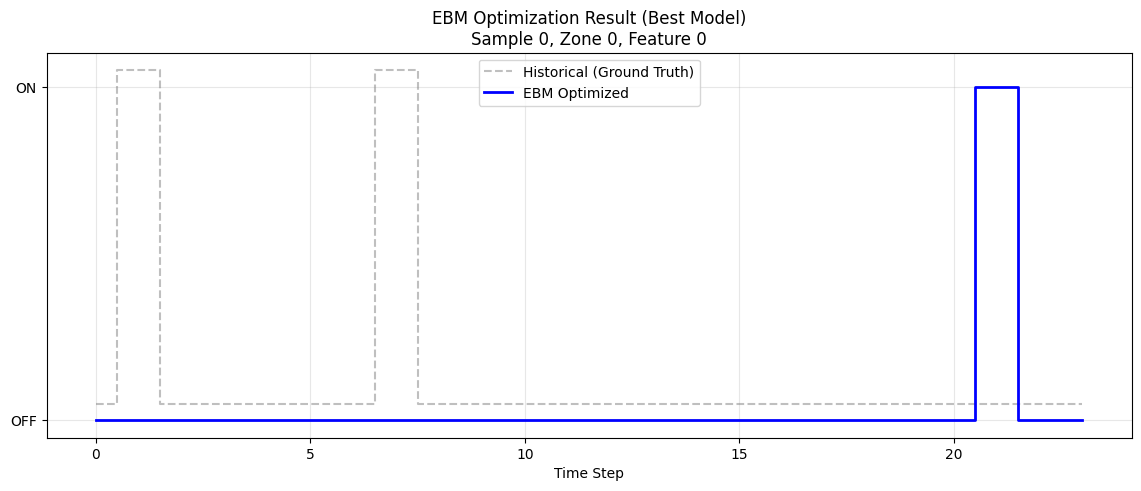

In [96]:
# ==============================================================================
# 11. VISUALIZATION (Run this after you stop training)
# ==============================================================================
import matplotlib.pyplot as plt
import torch

def visualize_trajectory(model, sampler, val_loader, device):
    """
    Loads the BEST model and plots a comparison.
    """
    # 1. Load the best checkpoint (safeguard against overfitting in later epochs)
    print("🔄 Loading the absolute best checkpoint...")
    output_dir = CONFIG["output_dir"]
    ckpt_path = os.path.join(output_dir, "temporal_ebm_best.pt")
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Loaded. Best Val Score: {checkpoint.get('best_score', 'N/A'):.4f}")

    # 2. Get a sample
    batch = next(iter(val_loader))
    h_zt = batch["h_zt"].to(device)
    mask = batch["zone_mask"].to(device)
    u_gt = batch["u_zt"].to(device)

    # 3. Optimize (Inference Mode)
    # We use a strict inference sampler here
    sampler.set_mode("infer")
    sampler.num_steps = 100
    sampler.noise_scale = 0.2

    print("⚡ Optimizing schedule...")
    u_opt = sampler.sample_binary(h_zt, zone_mask=mask, binarize="threshold", threshold=0.5)

    # 4. Plot
    idx = 0     # First sample in batch
    feat = 0    # First feature (e.g., Status)

    plt.figure(figsize=(14, 5))

    # Plot Ground Truth
    gt_curve = u_gt[idx, 0, :, feat].cpu().numpy()
    plt.step(range(len(gt_curve)), gt_curve + 0.05, where='mid',
             label='Historical (Ground Truth)', color='gray', linestyle='--', alpha=0.5)

    # Plot EBM Optimized
    opt_curve = u_opt[idx, 0, :, feat].cpu().numpy()
    plt.step(range(len(opt_curve)), opt_curve, where='mid',
             label='EBM Optimized', color='blue', linewidth=2)

    plt.title(f"EBM Optimization Result (Best Model)\nSample {idx}, Zone 0, Feature {feat}")
    plt.yticks([0, 1], ["OFF", "ON"])
    plt.xlabel("Time Step")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Run this when you are ready!
visualize_trajectory(model, sampler, val_loader, CONFIG['device'])

## 11. Plot Training Curves

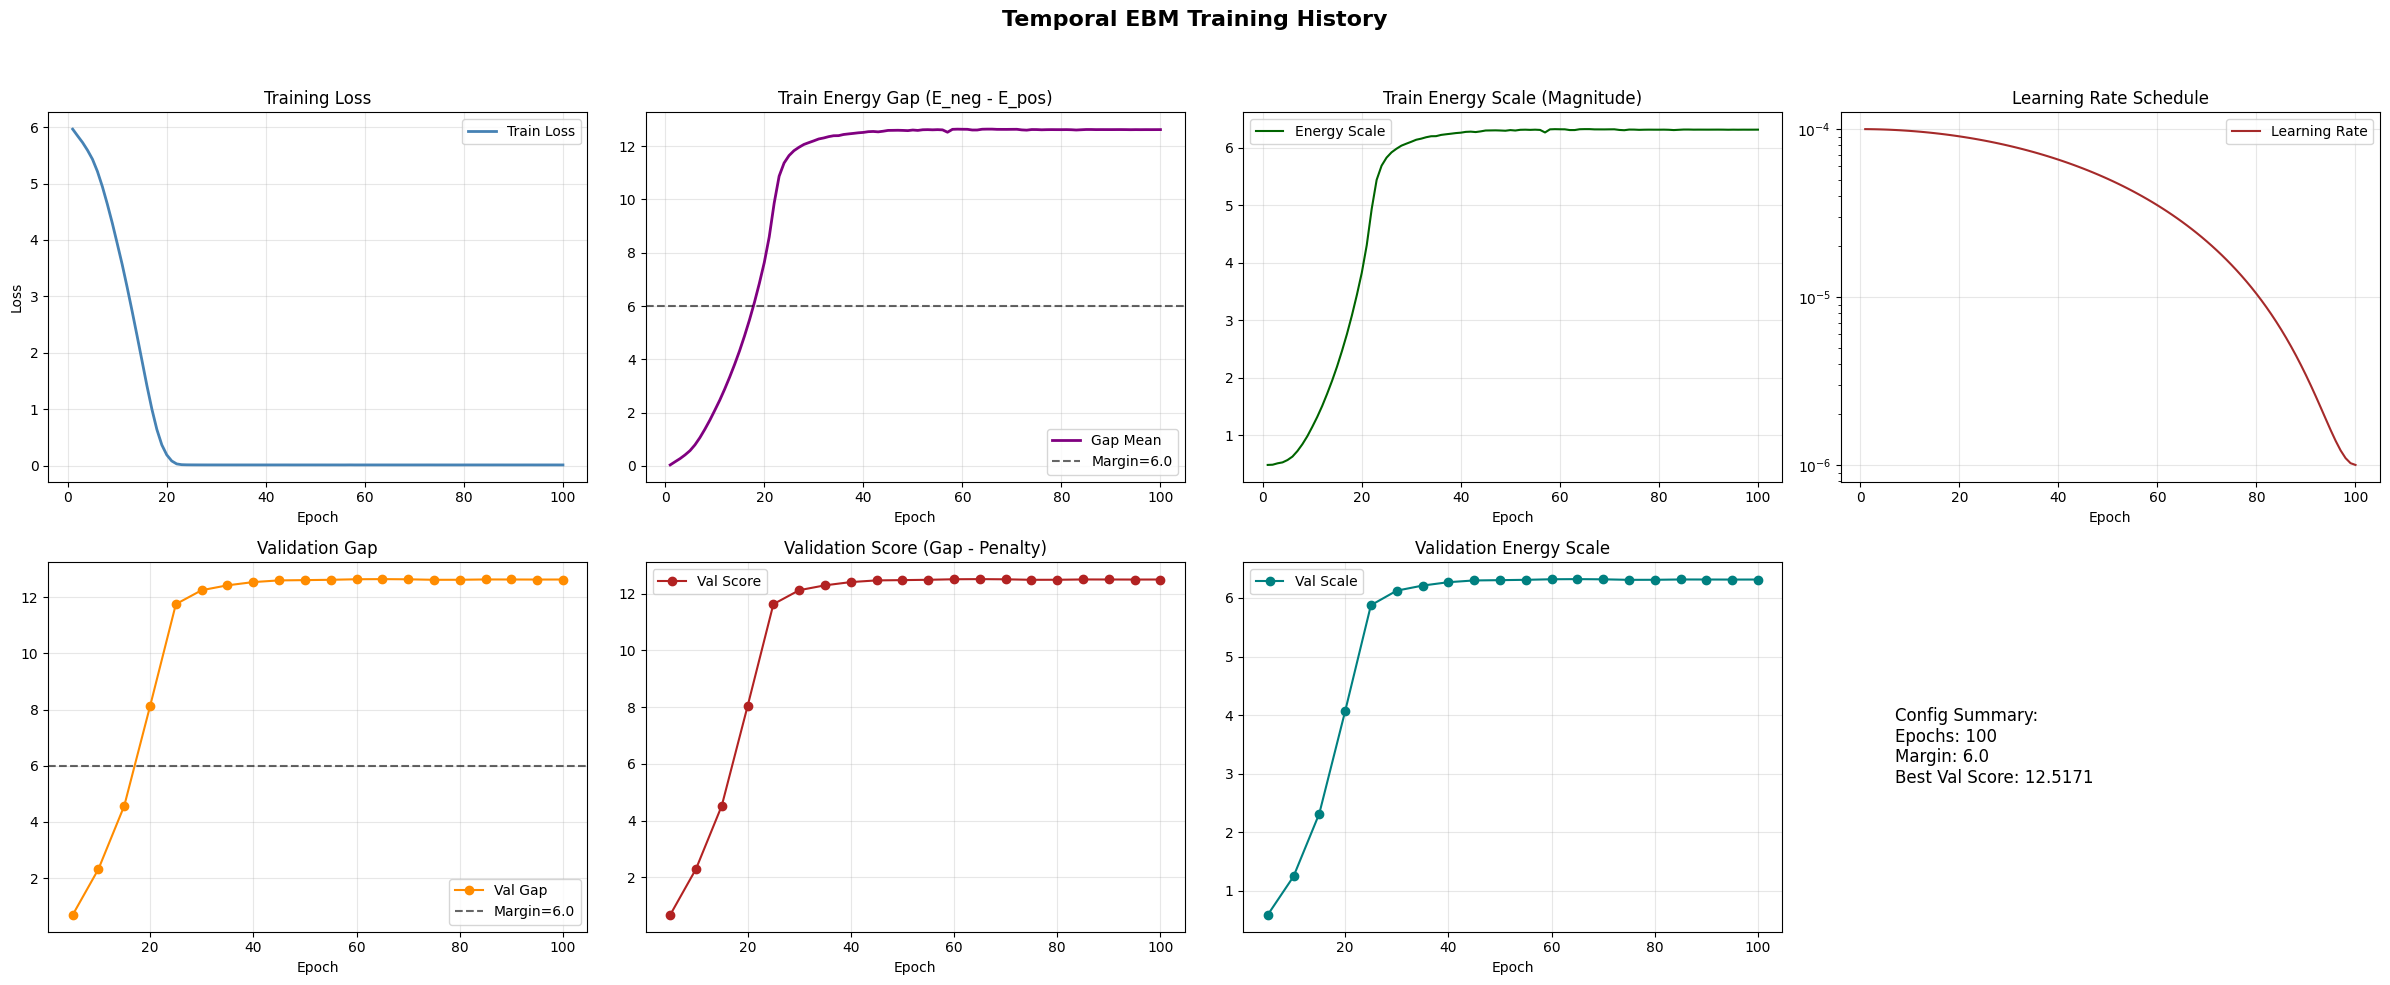

✅ Training plots saved to: /content/drive/MyDrive/benchmark/outputs/ebm_models/temporal_ebm_training_history.png


In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Récupération de la config
save_dir = CONFIG.get("output_dir", ".")
os.makedirs(save_dir, exist_ok=True)
margin = float(CONFIG.get("margin", 0.0))
validate_every = int(CONFIG.get("validate_every", 5))

# Création des axes X (Epochs)
epochs = np.arange(1, len(history["train_loss"]) + 1)
val_epochs = []
if "val_gap" in history and len(history["val_gap"]) > 0:
    val_epochs = np.arange(1, len(history["val_gap"]) + 1) * validate_every

# Configuration de la figure (2 lignes x 4 colonnes pour être compact)
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

# ------------------------------------------------------------------
# 1) Train Loss
# ------------------------------------------------------------------
ax = axes[0]
if "train_loss" in history:
    ax.plot(epochs, history["train_loss"], label="Train Loss", color="steelblue", linewidth=2)
    ax.set_title("Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 2) Train Gap
# ------------------------------------------------------------------
ax = axes[1]
if "train_gap" in history:
    ax.plot(epochs, history["train_gap"], label="Gap Mean", color="purple", linewidth=2)
    if margin > 0:
        ax.axhline(margin, color="black", linestyle="--", alpha=0.6, label=f"Margin={margin}")
    ax.set_title("Train Energy Gap (E_neg - E_pos)")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 3) Train Energy Scale (Global)
# ------------------------------------------------------------------
# Note: Ton training ne sauvegarde pas E_pos/E_neg séparément, mais 'train_energy_scale'
ax = axes[2]
if "train_energy_scale" in history:
    ax.plot(epochs, history["train_energy_scale"], label="Energy Scale", color="darkgreen")
    ax.set_title("Train Energy Scale (Magnitude)")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 4) Learning Rate
# ------------------------------------------------------------------
ax = axes[3]
if "lr" in history:
    ax.plot(epochs, history["lr"], label="Learning Rate", color="brown")
    ax.set_yscale("log")
    ax.set_title("Learning Rate Schedule")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 5) Validation Gap
# ------------------------------------------------------------------
ax = axes[4]
if len(val_epochs) > 0 and "val_gap" in history:
    ax.plot(val_epochs, history["val_gap"], marker="o", label="Val Gap", color="darkorange")
    if margin > 0:
        ax.axhline(margin, color="black", linestyle="--", alpha=0.6, label=f"Margin={margin}")
    ax.set_title("Validation Gap")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()
else:
    ax.text(0.5, 0.5, "No Validation Data", ha='center', va='center')

# ------------------------------------------------------------------
# 6) Validation Score (Metric de sélection)
# ------------------------------------------------------------------
ax = axes[5]
if len(val_epochs) > 0 and "val_score" in history:
    ax.plot(val_epochs, history["val_score"], marker="o", label="Val Score", color="firebrick")
    ax.set_title("Validation Score (Gap - Penalty)")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 7) Validation Energy Scale
# ------------------------------------------------------------------
ax = axes[6]
if len(val_epochs) > 0 and "val_energy_scale" in history:
    ax.plot(val_epochs, history["val_energy_scale"], marker="o", label="Val Scale", color="teal")
    ax.set_title("Validation Energy Scale")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ------------------------------------------------------------------
# 8) Case vide (ou infos textuelles)
# ------------------------------------------------------------------
ax = axes[7]
ax.axis("off")
info_text = (
    f"Config Summary:\n"
    f"Epochs: {len(epochs)}\n"
    f"Margin: {margin}\n"
    f"Best Val Score: {max(history.get('val_score', [-np.inf])):.4f}"
)
ax.text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center')


plt.suptitle("Temporal EBM Training History", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

out_path = os.path.join(save_dir, "temporal_ebm_training_history.png")
plt.savefig(out_path, dpi=150)
plt.show()

print(f"✅ Training plots saved to: {out_path}")

## 12. Save Training History

In [126]:
import json
import os

# --- 1. Save history as JSON ---
history_path = os.path.join(CONFIG['output_dir'], 'temporal_ebm_zonal_training_history.json')

with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to {history_path}")

# --- 2. Save config ---
# (Votre code de nettoyage est excellent pour gérer les objets non-serialisables comme torch.device)
config_path = os.path.join(CONFIG['output_dir'], 'temporal_ebm_zonal_config.json')
with open(config_path, 'w') as f:
    # Convert non-serializable types (Path, device, etc.) to string
    config_save = {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v
                   for k, v in CONFIG.items()}
    json.dump(config_save, f, indent=2)

print(f"✓ Config saved to {config_path}")

# --- 3. Print summary statistics ---
print("\n" + "=" * 60)
print("TRAINING STATISTICS")
print("=" * 60)
print(f"Total epochs: {len(history['train_loss'])}")

# CORRECTION ICI : On utilise min() car un Gap négatif (-40) est meilleur qu'un Gap nul (-1)
if 'val_gap' in history and len(history['val_gap']) > 0:
    best_gap = max(history['val_gap'])
    print(f"Best validation gap: {best_gap:.4f} (Higher is better)")
else:
    print("Best validation gap: N/A")

print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final training gap: {history['train_gap'][-1]:.4f}")
print("=" * 60)

✓ Training history saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/temporal_ebm_zonal_training_history.json
✓ Config saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/temporal_ebm_zonal_config.json

TRAINING STATISTICS
Total epochs: 100
Best validation gap: 12.6435 (Lower is better)
Final training loss: 0.0102
Final training gap: 12.6226


## 13. Evaluate Best Model

In [20]:
# ==============================================================================
# INFERENCE SAMPLER — NormalizedTemporalLangevinSampler
# ==============================================================================

print("🧊 Initializing NormalizedTemporalLangevinSampler (INFER mode)...")

# Inference-time hyperparameters
INFER_CFG = {
    "num_steps": 100,          # more steps = better exploration
    "step_size": 0.02,         # smaller than train for stability
    "noise_scale": 0.3,        # exploration noise
    "temp_max": 0.3,
    "temp_min": 0.03,
    "init_mode": "bernoulli",      # start at sparsity prior
    "prior_p": 0.025,          # global sparsity target (can be scenario-level later)
    "prior_strength": 0.0,     # IMPORTANT: >0 only in INFER
}

model.eval()

sampler_infer = NormalizedTemporalLangevinSampler(
    model=model,
    n_features=N_FEATURES_PER_ZT,
    num_steps=INFER_CFG["num_steps"],
    step_size=INFER_CFG["step_size"],
    noise_scale=INFER_CFG["noise_scale"],
    temp_min=INFER_CFG["temp_min"],
    temp_max=INFER_CFG["temp_max"],
    init_mode=INFER_CFG["init_mode"],
    init_p=INFER_CFG["prior_p"],      # only used if bernoulli init
    prior_p=INFER_CFG["prior_p"],
    prior_strength=INFER_CFG["prior_strength"],
    device=CONFIG["device"],
)

print("✅ INFER sampler ready")
print(f"   steps: {sampler_infer.num_steps}")
print(f"   step_size: {sampler_infer.step_size}")
print(f"   noise_scale: {sampler_infer.noise_scale}")
print(f"   temp: {sampler_infer.temp_max} → {sampler_infer.temp_min}")
print(f"   prior_p: {sampler_infer.prior_p}")
print(f"   prior_strength: {sampler_infer.prior_strength}")
print(f"   init_mode: {sampler_infer.init_mode}")


🧊 Initializing NormalizedTemporalLangevinSampler (INFER mode)...
✅ NormalizedTemporalLangevinSampler init | mode=train | steps=100 | step=0.02 | noise=0.3 | T:0.3->0.03 | prior_p=0.0250 | logit(p)=-3.66 | λ=0.0
✅ INFER sampler ready
   steps: 100
   step_size: 0.02
   noise_scale: 0.3
   temp: 0.3 → 0.03
   prior_p: 0.025
   prior_strength: 0.0
   init_mode: bernoulli


📥 Loading best model checkpoint...
✅ Model loaded (Score: 12.5171)

⚡ Running Inference Sampler (100 steps, init='bernoulli')...


/tmp/ipython-input-1158996668.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(CONFIG["output_dir"], "temporal_ebm_best.pt"),



🔋 Calculating Energies...
   E_ground_truth (mean): -6.3788 ± 0.0074
   E_generated    (mean): -6.3812 ± 0.0010
   Energy Gap (Gen - GT): -0.0024
   👉 NOTE: Gap négatif = Le modèle préfère ses propres générations à la réalité (Over-optimization ou Mode Collapse)

📊 Computing Metrics (Masked)...
----------------------------------------
🎯 Accuracy:   95.09%
⚖️ F1 Score:   2.66%
🔍 Precision:  2.70%
📡 Recall:     2.61%
----------------------------------------
📉 Activity (Ground Truth): 2.56%
📈 Activity (Generated):    2.48%
----------------------------------------

🎨 Visualizing random sample...


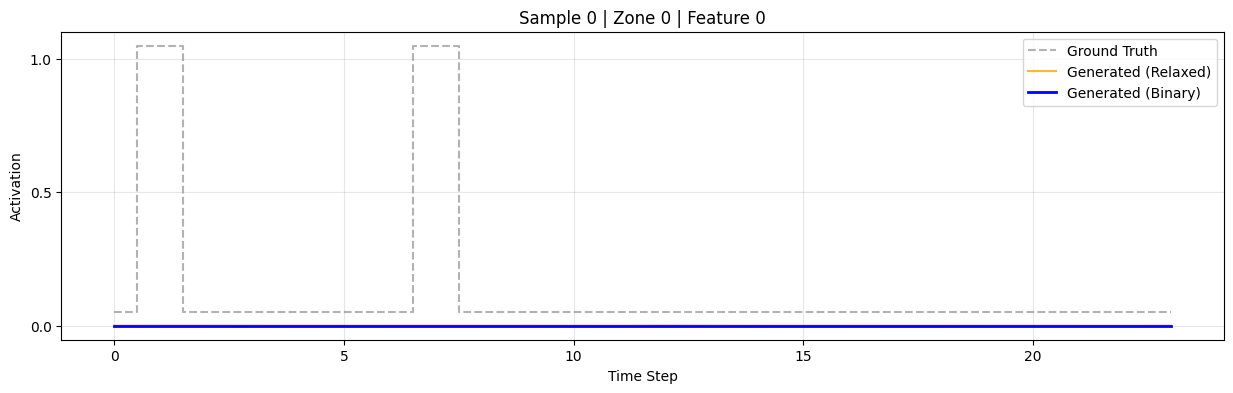

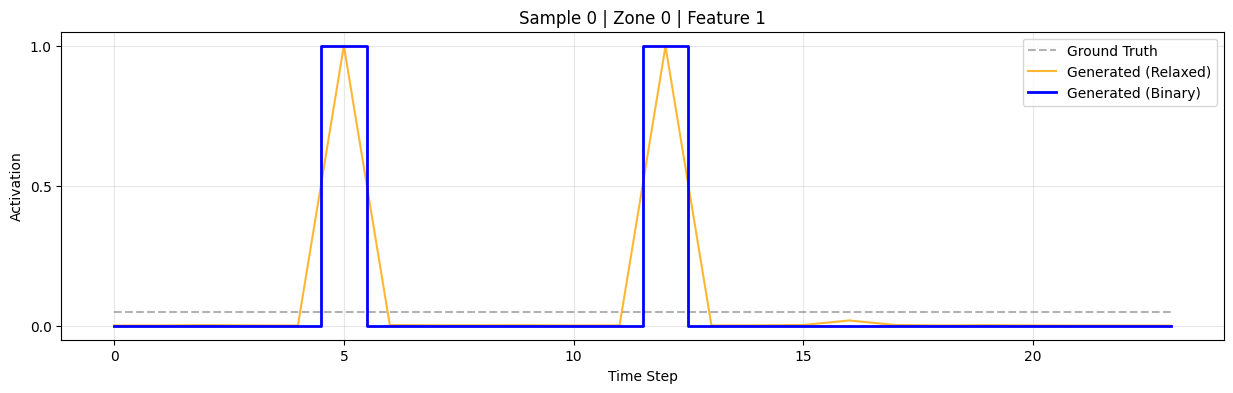

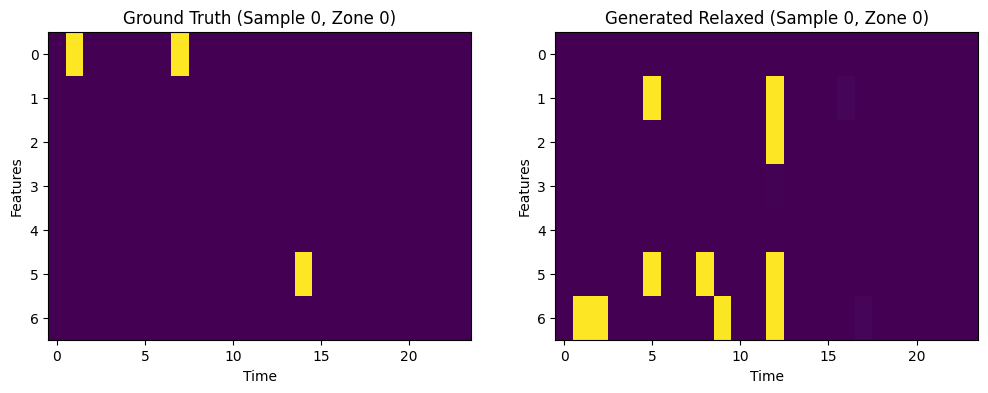

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# 🛠️ EVALUATION UTILS
# ==============================================================================

def get_masked_metrics(u_true, u_pred_bin, mask):
    """
    Calcule les métriques de classification (Acc, Prec, Rec, F1)
    en ignorant les zones de padding.

    Args:
        u_true: [B, Z, T, F] (binaire)
        u_pred_bin: [B, Z, T, F] (binaire 0/1)
        mask: [B, Z] (1=valide, 0=padding)
    """
    # Expansion du masque pour matcher les dimensions [B, Z, T, F]
    # mask: [B, Z] -> [B, Z, 1, 1] -> broadcast
    mask_expanded = mask.view(u_true.shape[0], u_true.shape[1], 1, 1).expand_as(u_true).bool()

    # Aplatir et filtrer par le masque
    y_true = u_true[mask_expanded].cpu().numpy().flatten()
    y_pred = u_pred_bin[mask_expanded].cpu().numpy().flatten()

    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Métriques
    eps = 1e-9
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1 = 2 * (prec * rec) / (prec + rec + eps)

    # Activité (Sparsity)
    activity_true = y_true.mean()
    activity_pred = y_pred.mean()

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Activity (True)": activity_true,
        "Activity (Pred)": activity_pred,
        "TP": tp, "FP": fp, "FN": fn
    }

def plot_comparison(u_true, u_gen, u_bin, b_idx, z_idx, f_idx=0):
    """Visualise la comparaison temporelle pour une feature donnée"""
    plt.figure(figsize=(15, 4))

    # Ground Truth
    gt = u_true[b_idx, z_idx, :, f_idx].cpu()
    plt.step(range(len(gt)), gt + 0.05, where='mid', label='Ground Truth',
             color='grey', linestyle='--', alpha=0.6)

    # Relaxed Generation (Probabilities)
    gen = u_gen[b_idx, z_idx, :, f_idx].cpu()
    plt.plot(range(len(gen)), gen, label='Generated (Relaxed)',
             color='orange', alpha=0.8, linewidth=1.5)

    # Binary Generation
    bin_gen = u_bin[b_idx, z_idx, :, f_idx].cpu()
    plt.step(range(len(bin_gen)), bin_gen, where='mid', label='Generated (Binary)',
             color='blue', linewidth=2)

    plt.title(f"Sample {b_idx} | Zone {z_idx} | Feature {f_idx}")
    plt.yticks([0, 0.5, 1])
    plt.ylabel("Activation")
    plt.xlabel("Time Step")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==============================================================================
# 🚀 FULL EVALUATION RUN
# ==============================================================================

# 1. Configuration & Chargement
# -----------------------------
print("📥 Loading best model checkpoint...")
try:
    checkpoint = torch.load(os.path.join(CONFIG["output_dir"], "temporal_ebm_best.pt"),
                           map_location=CONFIG["device"])
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded (Score: {checkpoint.get('best_score', 'N/A'):.4f})")
except FileNotFoundError:
    print("⚠️ Checkpoint not found, using current model weights.")

model.eval()
threshold = 0.5  # Seuil pour binariser la sortie relaxée

# 2. Exécution sur un batch de validation
# ---------------------------------------
print(f"\n⚡ Running Inference Sampler ({INFER_CFG['num_steps']} steps, init='{INFER_CFG['init_mode']}')...")

# Récupérer un batch
batch = next(iter(val_loader))
u_zt_true = batch['u_zt'].to(CONFIG['device'])
h_zt = batch['h_zt'].to(CONFIG['device'])
zone_mask = batch['zone_mask'].to(CONFIG['device'])

# Génération (Langevin Dynamics)
# Note: On utilise sample_relaxed pour voir les "probabilités" avant seuillage
# Le sampler est initialisé avec init_mode='bernoulli' (bruit aléatoire épars)
u_gen_relaxed = sampler_infer.sample_relaxed(h_zt, zone_mask=zone_mask).detach()

# Binarisation
u_gen_bin = (u_gen_relaxed > threshold).float()

# 3. Calcul des Énergies
# ----------------------
print("\n🔋 Calculating Energies...")
with torch.no_grad():
    # Energie de la vérité terrain
    E_pos = model(u_zt_true, h_zt, zone_mask)
    # Energie de la génération
    E_gen = model(u_gen_bin, h_zt, zone_mask) # On évalue l'énergie du résultat binaire final

gap = E_gen.mean() - E_pos.mean()

print(f"   E_ground_truth (mean): {E_pos.mean():.4f} ± {E_pos.std():.4f}")
print(f"   E_generated    (mean): {E_gen.mean():.4f} ± {E_gen.std():.4f}")
print(f"   Energy Gap (Gen - GT): {gap:.4f}")
if gap < 0:
    print("   👉 NOTE: Gap négatif = Le modèle préfère ses propres générations à la réalité (Over-optimization ou Mode Collapse)")
else:
    print("   👉 NOTE: Gap positif = La réalité a toujours une énergie plus basse (Bon signe si < Margin)")

# 4. Calcul des Métriques
# -----------------------
print("\n📊 Computing Metrics (Masked)...")
metrics = get_masked_metrics(u_zt_true, u_gen_bin, zone_mask)

print("-" * 40)
print(f"🎯 Accuracy:   {metrics['Accuracy']:.2%}")
print(f"⚖️ F1 Score:   {metrics['F1 Score']:.2%}")
print(f"🔍 Precision:  {metrics['Precision']:.2%}")
print(f"📡 Recall:     {metrics['Recall']:.2%}")
print("-" * 40)
print(f"📉 Activity (Ground Truth): {metrics['Activity (True)']:.2%}")
print(f"📈 Activity (Generated):    {metrics['Activity (Pred)']:.2%}")
print("-" * 40)

# 5. Visualisation
# ----------------
print("\n🎨 Visualizing random sample...")
# Choisir un index valide (non masqué)
b_idx = 0
valid_zones = torch.nonzero(zone_mask[b_idx]).flatten()
if len(valid_zones) > 0:
    z_idx = valid_zones[0].item()

    # Plot Feature 0 (souvent Status ou Activation)
    plot_comparison(u_zt_true, u_gen_relaxed, u_gen_bin, b_idx, z_idx, f_idx=0)

    # Si plus d'une feature, plot la Feature 1
    if u_zt_true.shape[-1] > 1:
        plot_comparison(u_zt_true, u_gen_relaxed, u_gen_bin, b_idx, z_idx, f_idx=1)
else:
    print("⚠️ No valid zone found in batch index 0.")

# 6. Heatmap globale (pour vérifier l'effondrement ou le bruit)
# -------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(u_zt_true[b_idx, z_idx].cpu().T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
plt.title("Ground Truth (Sample 0, Zone 0)")
plt.ylabel("Features")
plt.xlabel("Time")

plt.subplot(1, 2, 2)
plt.imshow(u_gen_relaxed[b_idx, z_idx].cpu().T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
plt.title("Generated Relaxed (Sample 0, Zone 0)")
plt.ylabel("Features")
plt.xlabel("Time")
plt.show()

🧊 Loading Best Temporal Model from: /content/drive/MyDrive/benchmark/outputs/ebm_models/temporal_ebm_best.pt
📦 Val batch shapes: u_pos=(128, 109, 24, 7), h_zt=(128, 109, 24, 128), mask=(128, 109)
   Real mean activity (masked): 0.025603
🎨 Sampling negatives with Langevin (single run, internal init)...
   steps=100, threshold=0.5

⚡ Energy diagnostics:
   E_pos mean : -6.3788
   E_neg mean : -6.3812
   Gap (E_neg - E_pos): -0.0024

📊 Generation stats (masked):
   MSE(relaxed): 0.049145
   BCE(relaxed): 0.447995
   Accuracy:     0.950836
   Precision:    0.025337
   Recall:       0.024561
   F1:           0.024943
   Real mean activity:         0.025603
   Gen  mean activity (relaxed): 0.024931
   Gen  mean activity (binary):  0.024819
   Gen saturation: P(u<0.01)=0.975 | P(u>0.99)=0.025

📊 Bernoulli binarization stats:
   Mean activity (Bernoulli): 0.024950
   Accuracy:  0.950714
   Precision: 0.025377
   Recall:    0.024730
   F1:        0.025050


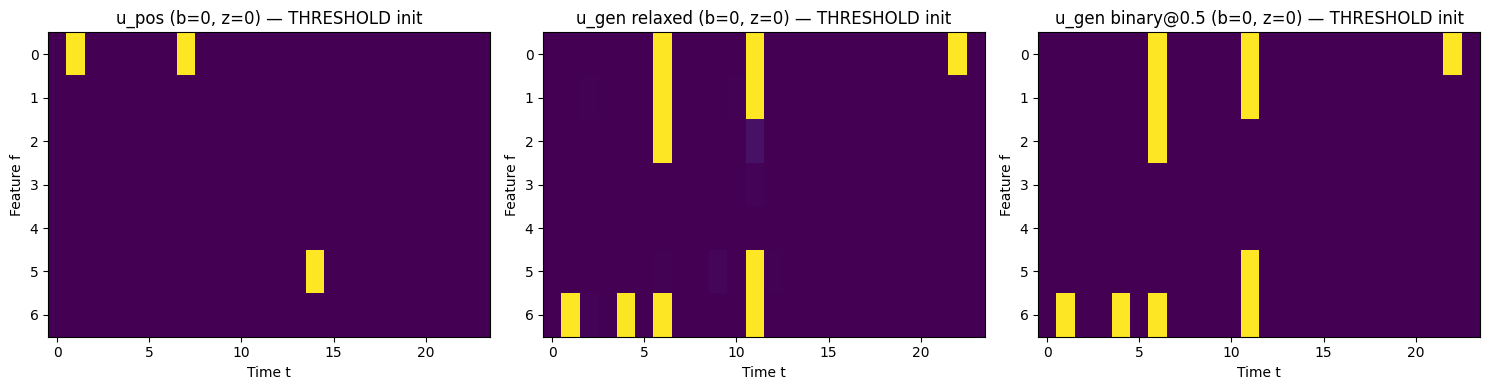

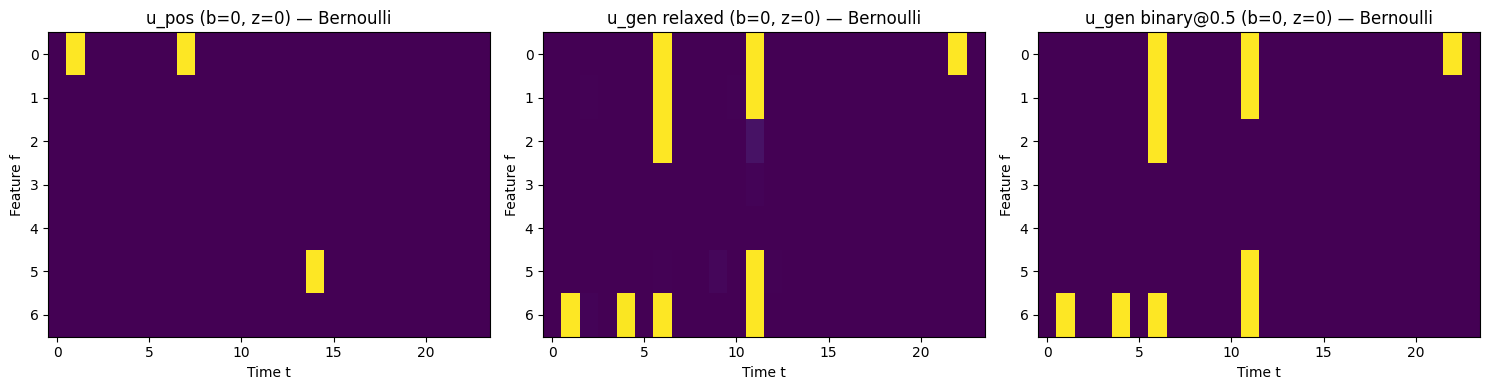


✅ Evaluation complete!


In [22]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# EVALUATION CELL — Temporal Zonal EBM + NormalizedTemporalLangevinSampler (1 init)
#   - Loads best checkpoint
#   - Samples ONCE using sampler's internal init
#   - Computes energies + proper masked metrics (MSE, BCE, accuracy, precision/recall/F1)
#   - Reports mean activity + saturation
#   - Visualizes one (b,z) slice
#
# Assumptions:
#   batch keys: "u_zt" [B,Z,T,F], "h_zt" [B,Z,T,D], "zone_mask" [B,Z]
#   model(u, h_zt, zone_mask) -> energy per sample (shape [B] or broadcastable)
#   sampler_infer is an instance of NormalizedTemporalLangevinSampler (INFER mode)
#   sampler_infer.sample(h_zt, zone_mask) returns u_bin OR u_relaxed depending on your class
#     - If your sampler returns binary, metrics still work (BCE will be noisy but OK).
#     - If you want relaxed samples, use sampler_infer.sample_relaxed(...)
# ==============================================================================

device = CONFIG["device"]
output_dir = CONFIG["output_dir"]
ckpt_path = os.path.join(output_dir, "temporal_ebm_best.pt")

# If your sampler returns binary, thresholding is redundant but harmless
threshold = float(CONFIG.get("threshold", 0.5))
n_steps_eval = int(CONFIG.get("eval_langevin_steps", getattr(sampler_infer, "num_steps", 100)))

eps = 1e-9

def _mask_full(x, mask4):
    # mask4: [B,Z,1,1] -> [B,Z,T,F]
    return mask4.expand_as(x)

def _masked_mean(x, mask4):
    m = _mask_full(x, mask4)
    denom = m.sum() + eps
    return (x * m).sum() / denom

def _masked_mse(u_pred, u_true, mask4):
    m = _mask_full(u_true, mask4)
    denom = m.sum() + eps
    per = (u_pred - u_true).pow(2)
    return (per * m).sum() / denom

def _masked_bce(u_pred, u_true, mask4):
    m = _mask_full(u_true, mask4)
    denom = m.sum() + eps
    u_pred = u_pred.clamp(1e-6, 1 - 1e-6)
    per = torch.nn.functional.binary_cross_entropy(u_pred, u_true, reduction="none")
    return (per * m).sum() / denom

def _masked_confusion(u_pred_bin, u_true, mask4, true_thr=0.5):
    m = _mask_full(u_true, mask4).bool().reshape(-1)
    yt = (u_true.reshape(-1) > true_thr)
    yp = (u_pred_bin.reshape(-1) > 0.5)

    yt = yt[m]
    yp = yp[m]

    tp = (yp & yt).float().sum()
    fp = (yp & ~yt).float().sum()
    tn = (~yp & ~yt).float().sum()
    fn = (~yp & yt).float().sum()
    return tp, fp, tn, fn

def _metrics_from_confusion(tp, fp, tn, fn):
    acc = (tp + tn) / (tp + fp + tn + fn + eps)
    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1 = 2 * prec * rec / (prec + rec + eps)
    return acc, prec, rec, f1

def _saturation(u, mask4, thr=0.01):
    m = mask4.expand_as(u) > 0
    denom = m.float().sum() + eps
    near0 = ((u < thr) & m).float().sum() / denom
    near1 = ((u > 1 - thr) & m).float().sum() / denom
    return float(near0.item()), float(near1.item())

def _pick_bz(zone_mask):
    B, Z = zone_mask.shape
    for b in range(B):
        valid_z = torch.where(zone_mask[b] > 0)[0]
        if len(valid_z) > 0:
            return b, int(valid_z[0].item())
    return 0, 0

def _plot_triplet(u_pos_bz, u_gen_bz, u_bin_bz, title_suffix=""):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(u_pos_bz.T, aspect="auto", vmin=0, vmax=1)
    axes[0].set_title(f"u_pos {title_suffix}")
    axes[0].set_xlabel("Time t"); axes[0].set_ylabel("Feature f")

    axes[1].imshow(u_gen_bz.T, aspect="auto", vmin=0, vmax=1)
    axes[1].set_title(f"u_gen relaxed {title_suffix}")
    axes[1].set_xlabel("Time t"); axes[1].set_ylabel("Feature f")

    axes[2].imshow(u_bin_bz.T, aspect="auto", vmin=0, vmax=1)
    axes[2].set_title(f"u_gen binary@{threshold} {title_suffix}")
    axes[2].set_xlabel("Time t"); axes[2].set_ylabel("Feature f")

    plt.tight_layout()
    plt.show()



# ------------------------------------------------------------------------------
# 0) Guards
# ------------------------------------------------------------------------------
assert "sampler_infer" in globals(), "Run the INFER sampler init cell first (sampler_infer)."

# ------------------------------------------------------------------------------
# 1) Load best checkpoint
# ------------------------------------------------------------------------------
print(f"🧊 Loading Best Temporal Model from: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

model.load_state_dict(state_dict)
model.to(device)

# ------------------------------------------------------------------------------
# 2) Grab one validation batch
# ------------------------------------------------------------------------------
batch = next(iter(val_loader))
u_pos = batch["u_zt"].to(device)           # [B,Z,T,F]
h_zt  = batch["h_zt"].to(device)           # [B,Z,T,D]
zone_mask = batch["zone_mask"].to(device)  # [B,Z]

B, Z, T, F = u_pos.shape
mask4 = zone_mask.view(B, Z, 1, 1).float()

print(f"📦 Val batch shapes: u_pos={tuple(u_pos.shape)}, h_zt={tuple(h_zt.shape)}, mask={tuple(zone_mask.shape)}")
real_mean = float(_masked_mean(u_pos, mask4).item())
print(f"   Real mean activity (masked): {real_mean:.6f}")

# ------------------------------------------------------------------------------
# 3) Configure sampler (INFER) steps
# ------------------------------------------------------------------------------
if hasattr(sampler_infer, "num_steps"):
    sampler_infer.num_steps = n_steps_eval

print("🎨 Sampling negatives with Langevin (single run, internal init)...")
print(f"   steps={n_steps_eval}, threshold={threshold}")

# ------------------------------------------------------------------------------
# 4) Sample once
# ------------------------------------------------------------------------------
# bruit "oracle"

model.train()  # si ton sampler a besoin du mode train pour GRU cudnn backward
u_gen= sampler_infer.sample_relaxed(h_zt, zone_mask).detach()

# ------------------------------------------------------------------
# B) Bernoulli binarization (EBM-consistent)
# ------------------------------------------------------------------
# Draw hard samples according to learned probabilities
u_bin_bern = torch.bernoulli(u_gen) * mask4


# ------------------------------------------------------------------------------
# 5) Energies + gap
# ------------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    E_pos = model(u_pos, h_zt, zone_mask)
    E_neg = model(u_gen, h_zt, zone_mask)

Epos_m = float(E_pos.mean().item())
Eneg_m = float(E_neg.mean().item())
gap_m  = float((E_neg.mean() - E_pos.mean()).item())

print("\n⚡ Energy diagnostics:")
print(f"   E_pos mean : {Epos_m:.4f}")
print(f"   E_neg mean : {Eneg_m:.4f}")
print(f"   Gap (E_neg - E_pos): {gap_m:.4f}")

# ------------------------------------------------------------------------------
# 6) Masked metrics + sparse-class metrics
# ------------------------------------------------------------------------------
u_bin = (u_gen > threshold).float()

mse = float(_masked_mse(u_gen, u_pos, mask4).item())
bce = float(_masked_bce(u_gen, u_pos, mask4).item())

tp, fp, tn, fn = _masked_confusion(u_bin, u_pos, mask4)
acc, prec, rec, f1 = _metrics_from_confusion(tp, fp, tn, fn)

gen_mean = float(_masked_mean(u_gen, mask4).item())
gen_bin_mean = float(_masked_mean(u_bin, mask4).item())
near0, near1 = _saturation(u_gen, mask4, thr=0.01)

print("\n📊 Generation stats (masked):")
print(f"   MSE(relaxed): {mse:.6f}")
print(f"   BCE(relaxed): {bce:.6f}")
print(f"   Accuracy:     {float(acc.item()):.6f}")
print(f"   Precision:    {float(prec.item()):.6f}")
print(f"   Recall:       {float(rec.item()):.6f}")
print(f"   F1:           {float(f1.item()):.6f}")
print(f"   Real mean activity:         {real_mean:.6f}")
print(f"   Gen  mean activity (relaxed): {gen_mean:.6f}")
print(f"   Gen  mean activity (binary):  {gen_bin_mean:.6f}")
print(f"   Gen saturation: P(u<0.01)={near0:.3f} | P(u>0.99)={near1:.3f}")

# ------------------------------------------------------------------
# Metrics for Bernoulli binarization
# ------------------------------------------------------------------
tp_b, fp_b, tn_b, fn_b = _masked_confusion(u_bin_bern, u_pos, mask4)
acc_b, prec_b, rec_b, f1_b = _metrics_from_confusion(tp_b, fp_b, tn_b, fn_b)

bern_mean = float(_masked_mean(u_bin_bern, mask4).item())

print("\n📊 Bernoulli binarization stats:")
print(f"   Mean activity (Bernoulli): {bern_mean:.6f}")
print(f"   Accuracy:  {float(acc_b.item()):.6f}")
print(f"   Precision: {float(prec_b.item()):.6f}")
print(f"   Recall:    {float(rec_b.item()):.6f}")
print(f"   F1:        {float(f1_b.item()):.6f}")


# ------------------------------------------------------------------------------
# 7) Visualize one (b,z) slice
# ------------------------------------------------------------------------------
b, z = _pick_bz(zone_mask)
u_pos_bz = u_pos[b, z].detach().cpu().numpy()
u_gen_bz = u_gen[b, z].detach().cpu().numpy()
u_bin_bz = u_bin[b, z].detach().cpu().numpy()

u_bin_bz_bern = u_bin_bern[b, z].detach().cpu().numpy()

_plot_triplet(u_pos_bz, u_gen_bz, u_bin_bz, title_suffix=f"(b={b}, z={z}) — THRESHOLD init")

_plot_triplet(u_pos_bz, u_gen_bz, u_bin_bz_bern,
              title_suffix=f"(b={b}, z={z}) — Bernoulli")


print("\n✅ Evaluation complete!")


In [23]:
# ======================================================================
# Comprehensive Evaluation — Zone-Level EBM (DICT batches) [FIXED]
# ======================================================================

import os
import torch
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F_nn

device = CONFIG["device"]

# ----------------------------
# 1) Load best model
# ----------------------------
ckpt_path = os.path.join(CONFIG["output_dir"], "temporal_ebm_best.pt")
print(f"🧊 Loading best zone-level model from: {ckpt_path}")

ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

model.load_state_dict(state_dict)
model.to(device)

# ----------------------------
# 2) Helpers
# ----------------------------
def _as_numpy_list(x: torch.Tensor):
    return x.detach().cpu().view(-1).numpy().tolist()

def _binary_metrics(pred_bin, target_bin, mask, eps=1e-9):
    pred = (pred_bin * mask).view(-1)
    targ = (target_bin * mask).view(-1)
    tp = ((pred == 1) & (targ == 1)).float().sum()
    fp = ((pred == 1) & (targ == 0)).float().sum()
    fn = ((pred == 0) & (targ == 1)).float().sum()
    tn = ((pred == 0) & (targ == 0)).float().sum()
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    acc  = (tp + tn) / (tp + tn + fp + fn + eps)
    return float(acc.item()), float(prec.item()), float(rec.item()), float(f1.item())

# ----------------------------
# 3) Accumulators
# ----------------------------
all_e_pos, all_e_neg, all_gap = [], [], []
all_mse, all_bce = [], []
all_acc, all_prec, all_rec, all_f1 = [], [], [], []

print("🔍 Evaluating Zone-Level EBM on validation set...")
first = True

for batch in tqdm(val_loader, desc="Eval"):
    if first:
        print("🔑 Batch keys:", list(batch.keys()))
        first = False

    # CASE B — Dense masked batch (temporal)
    if ("u_zt" in batch) and ("h_zt" in batch) and ("zone_mask" in batch):
        u_pos = batch["u_zt"].to(device)
        h_zt  = batch["h_zt"].to(device)
        zone_mask = batch["zone_mask"].to(device)

        # ⚠️ MUST be in train mode for cuDNN GRU backward in sampler
        model.train()
        u_neg = sampler_infer.sample(h_zt, zone_mask)

        # Energies (no grad needed)
        with torch.no_grad():
            e_pos = model(u_pos, h_zt, zone_mask).view(-1)
            e_neg = model(u_neg, h_zt, zone_mask).view(-1)

        gap = (e_neg - e_pos)
        all_e_pos.extend(_as_numpy_list(e_pos))
        all_e_neg.extend(_as_numpy_list(e_neg))
        all_gap.extend(_as_numpy_list(gap))

        # Metrics (masked)
        mask = zone_mask.view(zone_mask.shape[0], zone_mask.shape[1], *([1] * (u_pos.ndim - 2))).float()
        thr = float(CONFIG.get("eval_threshold", 0.5))
        u_neg_bin = (u_neg > thr).float()

        mse = (F_nn.mse_loss(u_neg * mask, u_pos * mask, reduction="sum") /
               (mask.sum() * (u_pos.numel() / (mask.numel() + 1e-9)) + 1e-9)).item()

        bce = (F_nn.binary_cross_entropy((u_neg.clamp(1e-6, 1-1e-6) * mask),
                                         (u_pos * mask),
                                         reduction="sum") /
               (mask.sum() * (u_pos.numel() / (mask.numel() + 1e-9)) + 1e-9)).item()

        acc, prec, rec, f1 = _binary_metrics(u_neg_bin, u_pos, mask)

        all_mse.append(mse)
        all_bce.append(bce)
        all_acc.append(acc)
        all_prec.append(prec)
        all_rec.append(rec)
        all_f1.append(f1)

    else:
        raise KeyError("Unrecognized batch format.")

# ----------------------------
# 4) Summary
# ----------------------------
all_gap_arr = np.array(all_gap)

print("\n" + "=" * 70)
print("ZONE-LEVEL EBM — EVALUATION RESULTS")
print("=" * 70)

print("\n⚡ Energy statistics:")
print(f"   E_pos mean ± std : {np.mean(all_e_pos):.4f} ± {np.std(all_e_pos):.4f}")
print(f"   E_neg mean ± std : {np.mean(all_e_neg):.4f} ± {np.std(all_e_neg):.4f}")
print(f"   Gap  mean ± std  : {np.mean(all_gap):.4f} ± {np.std(all_gap):.4f}")

pct_good = 100.0 * np.mean(all_gap_arr > 0)
print(f"\n📏 % samples with E_neg > E_pos : {pct_good:.1f}%")

if len(all_mse) > 0:
    print("\n🎯 Generation quality:")
    print(f"   MSE mean ± std : {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
    print(f"   BCE mean ± std : {np.mean(all_bce):.4f} ± {np.std(all_bce):.4f}")
    print(f"   Acc mean ± std : {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print(f"   Precision      : {np.mean(all_prec):.4f}")
    print(f"   Recall         : {np.mean(all_rec):.4f}")
    print(f"   F1             : {np.mean(all_f1):.4f}")

print("=" * 70)
print("✅ Done.")

🧊 Loading best zone-level model from: /content/drive/MyDrive/benchmark/outputs/ebm_models/temporal_ebm_best.pt
🔍 Evaluating Zone-Level EBM on validation set...


Eval:   0%|          | 0/5 [00:00<?, ?it/s]

🔑 Batch keys: ['u_zt', 'h_zt', 'zone_mask', 'n_zones', 'n_timesteps', 'n_features', 'scenario_ids']

ZONE-LEVEL EBM — EVALUATION RESULTS

⚡ Energy statistics:
   E_pos mean ± std : -6.3330 ± 0.0136
   E_neg mean ± std : -6.3353 ± 0.0136
   Gap  mean ± std  : -0.0023 ± 0.0198

📏 % samples with E_neg > E_pos : 47.8%

🎯 Generation quality:
   MSE mean ± std : 0.0482 ± 0.0008
   BCE mean ± std : 0.4383 ± 0.0083
   Acc mean ± std : 0.9759 ± 0.0017
   Precision      : 0.0252
   Recall         : 0.0256
   F1             : 0.0254
✅ Done.


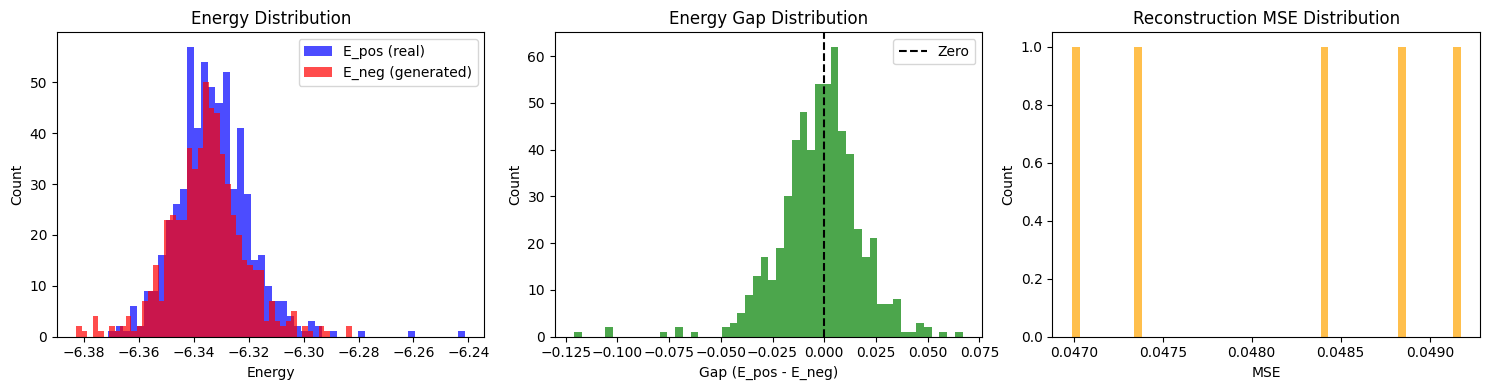

✓ Saved evaluation plots to /content/drive/MyDrive/benchmark/outputs/ebm_models


In [25]:
# Energy Distribution Visualization

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Energy distributions
axes[0].hist(all_e_pos, bins=50, alpha=0.7, label='E_pos (real)', color='blue')
axes[0].hist(all_e_neg, bins=50, alpha=0.7, label='E_neg (generated)', color='red')
axes[0].set_xlabel('Energy')
axes[0].set_ylabel('Count')
axes[0].set_title('Energy Distribution')
axes[0].legend()

# Gap distribution
axes[1].hist(all_gap, bins=50, alpha=0.7, color='green')
axes[1].axvline(x=0, color='black', linestyle='--', label='Zero')
axes[1].set_xlabel('Gap (E_pos - E_neg)')
axes[1].set_ylabel('Count')
axes[1].set_title('Energy Gap Distribution')
axes[1].legend()

# MSE distribution
axes[2].hist(all_mse, bins=50, alpha=0.7, color='orange')
axes[2].set_xlabel('MSE')
axes[2].set_ylabel('Count')
axes[2].set_title('Reconstruction MSE Distribution')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'zonal_ebm_eval_distributions.png'), dpi=150)
plt.show()

print(f"✓ Saved evaluation plots to {CONFIG['output_dir']}")

## 14. Sample and Analyze Configurations

In [26]:
# Sample Quality Analysis (fixed for dict batches)

import torch
import numpy as np

print("🎯 Sampling Quality Analysis...")

# Get a test batch (dict format)
test_batch = next(iter(val_loader))
u_pos = test_batch['u_zt'].to(device)
h_zt = test_batch['h_zt'].to(device)
zone_mask = test_batch['zone_mask'].to(device)

print(f"📦 Batch shapes: u_pos={tuple(u_pos.shape)}, h_zt={tuple(h_zt.shape)}")

sampled_energies = []
sampled_configs = []
num_samples = 10

# Ground truth energy
with torch.no_grad():
    E_true = model(u_pos, h_zt, zone_mask)
    print(f"Ground truth energy: {E_true.mean().item():.4f}")

# Sample multiple configurations
model.train()  # Required for cuDNN GRU backward in sampler

for i in range(num_samples):
    u_sample = sampler_infer.sample(h_zt, zone_mask)

    with torch.no_grad():
        E_sample = model(u_sample, h_zt, zone_mask)

    sampled_energies.append(E_sample.mean().item())
    sampled_configs.append(u_sample.cpu().numpy())

    print(f"  Sample {i+1}: E = {E_sample.mean().item():.4f}")

print(f"\n📊 Sampling Summary:")
print(f"   Ground truth E: {E_true.mean().item():.4f}")
print(f"   Sampled E (mean): {np.mean(sampled_energies):.4f}")
print(f"   Sampled E (std): {np.std(sampled_energies):.4f}")

ratio = np.mean(sampled_energies) / (E_true.mean().item() + 1e-9)
print(f"   Energy ratio (sampled/true): {ratio:.2f}")

# Gap analysis
gap = np.array(sampled_energies) - E_true.mean().item()
print(f"   Gap (E_sampled - E_true) mean: {gap.mean():.4f}")
print(f"   % samples with higher energy than true: {100 * (gap > 0).mean():.1f}%")

🎯 Sampling Quality Analysis...
📦 Batch shapes: u_pos=(128, 109, 24, 7), h_zt=(128, 109, 24, 128)
Ground truth energy: -6.3335
  Sample 1: E = -6.3324
  Sample 2: E = -6.3359
  Sample 3: E = -6.3365
  Sample 4: E = -6.3372
  Sample 5: E = -6.3371
  Sample 6: E = -6.3369
  Sample 7: E = -6.3370
  Sample 8: E = -6.3346
  Sample 9: E = -6.3384
  Sample 10: E = -6.3357

📊 Sampling Summary:
   Ground truth E: -6.3335
   Sampled E (mean): -6.3362
   Sampled E (std): 0.0016
   Energy ratio (sampled/true): 1.00
   Gap (E_sampled - E_true) mean: -0.0027
   % samples with higher energy than true: 10.0%


## 15. Langevin Sampler Evaluation

This section implements and evaluates a Langevin discretized sampler for binary variables, working with continuous logits and sigmoid relaxation.

In [27]:
# ======================================================================
# Binary Commitment Evaluation + Energy + Precision/Recall/F1
# ======================================================================

import torch
import numpy as np

print("🎯 Binary Commitment & Energy Evaluation...")

# ----------------------------------------------------------------------
# 1) Get a validation batch (dict format)
# ----------------------------------------------------------------------
test_batch = next(iter(val_loader))

u_pos = test_batch['u_zt'].to(device)        # [B, Z, T, F]
h_zt = test_batch['h_zt'].to(device)         # [B, Z, T, D]
zone_mask = test_batch['zone_mask'].to(device)  # [B, Z]

B, Z, T, F = u_pos.shape
print(f"📦 Batch: {B} samples, up to {Z} zones, {T} timesteps, {F} features")

# Expand mask for broadcasting
mask = zone_mask.view(B, Z, 1, 1).float()
total_valid = mask.sum() * T * F + 1e-9

# ----------------------------------------------------------------------
# 2) Sample from the model
# ----------------------------------------------------------------------
model.train()  # required for cuDNN GRU backward in sampler
u_sample = sampler_infer.sample(h_zt, zone_mask)   # [B, Z, T, F]

# Binarize
u_binary = (u_sample > 0.5).float()

# Ground truth (binary)
u_real_binary = (u_pos > 0.5).float()

# ----------------------------------------------------------------------
# 3) ENERGY DIAGNOSTICS
# ----------------------------------------------------------------------
model.eval()
with torch.no_grad():
    E_pos = model(u_pos, h_zt, zone_mask)
    E_neg = model(u_sample, h_zt, zone_mask)

E_pos_mean = E_pos.mean().item()
E_neg_mean = E_neg.mean().item()
gap_mean   = (E_neg - E_pos).mean().item()

print("\n⚡ Energy diagnostics:")
print(f"   E_pos mean : {E_pos_mean:.4f}")
print(f"   E_neg mean : {E_neg_mean:.4f}")
print(f"   Gap (E_neg - E_pos): {gap_mean:.4f}")

# ----------------------------------------------------------------------
# 4) ACCURACY (masked)
# ----------------------------------------------------------------------
matches = ((u_binary == u_real_binary).float() * mask)
binary_accuracy = matches.sum().item() / total_valid.item()

# Per-sample accuracy
sample_accs = []
for b in range(B):
    m_b = zone_mask[b].view(Z, 1, 1).float()
    valid_b = m_b.sum() * T * F + 1e-9
    acc_b = ((u_binary[b] == u_real_binary[b]).float() * m_b).sum().item() / valid_b.item()
    sample_accs.append(acc_b)

# ----------------------------------------------------------------------
# 5) PRECISION / RECALL / F1 (for class "1", masked)
# ----------------------------------------------------------------------
# True positives, false positives, false negatives
TP = ((u_binary == 1) & (u_real_binary == 1)).float() * mask
FP = ((u_binary == 1) & (u_real_binary == 0)).float() * mask
FN = ((u_binary == 0) & (u_real_binary == 1)).float() * mask

TP = TP.sum().item()
FP = FP.sum().item()
FN = FN.sum().item()

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1        = 2 * precision * recall / (precision + recall + 1e-9)

# ----------------------------------------------------------------------
# 6) ACTIVITY ANALYSIS
# ----------------------------------------------------------------------
pos_activity = (u_real_binary * mask).sum() / total_valid
gen_activity = (u_binary * mask).sum() / total_valid

# ----------------------------------------------------------------------
# 7) REPORT
# ----------------------------------------------------------------------
print("\n📊 Binary Commitment Results:")
print(f"   Overall accuracy: {binary_accuracy:.4f}")
print(f"   Per-sample accuracy (mean): {np.mean(sample_accs):.4f}")
print(f"   Per-sample accuracy (std):  {np.std(sample_accs):.4f}")
print(f"   Min sample accuracy:        {np.min(sample_accs):.4f}")
print(f"   Max sample accuracy:        {np.max(sample_accs):.4f}")

print("\n🎯 Sparse-class metrics (class = 1):")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 score:  {f1:.4f}")

print("\n📈 Activity Analysis:")
print(f"   Ground truth activity: {pos_activity.item():.4f}")
print(f"   Generated activity:    {gen_activity.item():.4f}")
print(f"   Activity ratio:        {gen_activity.item() / (pos_activity.item() + 1e-9):.2f}")

print("\n✅ Evaluation complete!")


🎯 Binary Commitment & Energy Evaluation...
📦 Batch: 128 samples, up to 109 zones, 24 timesteps, 7 features

⚡ Energy diagnostics:
   E_pos mean : -6.3788
   E_neg mean : -6.3812
   Gap (E_neg - E_pos): -0.0024

📊 Binary Commitment Results:
   Overall accuracy: 0.9507
   Per-sample accuracy (mean): 0.9486
   Per-sample accuracy (std):  0.0132
   Min sample accuracy:        0.8690
   Max sample accuracy:        0.9684

🎯 Sparse-class metrics (class = 1):
   Precision: 0.0251
   Recall:    0.0245
   F1 score:  0.0248

📈 Activity Analysis:
   Ground truth activity: 0.0256
   Generated activity:    0.0250
   Activity ratio:        0.97

✅ Evaluation complete!


In [28]:
# Constraint Satisfaction Analysis (fixed for dict batches)

import torch

print("⚡ Constraint Satisfaction Analysis...")

# Get test batch (dict format)
test_batch = next(iter(val_loader))
u_real = test_batch['u_zt'].to(device)       # [B, Z, T, F]
h_zt = test_batch['h_zt'].to(device)         # [B, Z, T, D]
zone_mask = test_batch['zone_mask'].to(device)  # [B, Z]

B, Z, T, F = u_real.shape

print(f"\n📊 Feature Analysis:")
print(f"   u_real shape: {tuple(u_real.shape)}")
print(f"   h_zt shape: {tuple(h_zt.shape)}")
print(f"   zone_mask shape: {tuple(zone_mask.shape)}")
print(f"   Batch size: {B}, Zones: {Z}, Timesteps: {T}, Features: {F}")

# Sample from the model (must be in train mode for cuDNN)
model.train()
u_sample = sampler_infer.sample(h_zt, zone_mask)
u_binary = (u_sample > 0.5).float()

# Mask for valid zones
mask = zone_mask.view(B, Z, 1, 1).float()
total_valid = mask.sum() * T * F

# Value distribution analysis (masked)
real_mean = (u_real * mask).sum() / (total_valid + 1e-9)
real_std = ((u_real * mask).pow(2).sum() / (total_valid + 1e-9) - real_mean.pow(2)).sqrt()

sample_mean = (u_sample * mask).sum() / (total_valid + 1e-9)
sample_std = ((u_sample * mask).pow(2).sum() / (total_valid + 1e-9) - sample_mean.pow(2)).sqrt()

binary_mean = (u_binary * mask).sum() / (total_valid + 1e-9)

print(f"\n📊 Value Distribution (masked):")
print(f"   Real u - mean: {real_mean.item():.4f}, std: {real_std.item():.4f}")
print(f"   Sampled u - mean: {sample_mean.item():.4f}, std: {sample_std.item():.4f}")
print(f"   Binary u - mean: {binary_mean.item():.4f}")

# Energy comparison
with torch.no_grad():
    E_real = model(u_real, h_zt, zone_mask)
    E_sample = model(u_sample, h_zt, zone_mask)
    E_binary = model(u_binary, h_zt, zone_mask)

print(f"\n📊 Energy Comparison:")
print(f"   Real data energy: {E_real.mean().item():.4f}")
print(f"   Sampled energy (relaxed): {E_sample.mean().item():.4f}")
print(f"   Binary energy: {E_binary.mean().item():.4f}")

# Energy gap analysis
gap_sample = (E_sample - E_real).mean().item()
gap_binary = (E_binary - E_real).mean().item()

print(f"\n📊 Energy Gap (higher = worse than real):")
print(f"   E_sample - E_real: {gap_sample:.4f}")
print(f"   E_binary - E_real: {gap_binary:.4f}")

⚡ Constraint Satisfaction Analysis...

📊 Feature Analysis:
   u_real shape: (128, 109, 24, 7)
   h_zt shape: (128, 109, 24, 128)
   zone_mask shape: (128, 109)
   Batch size: 128, Zones: 109, Timesteps: 24, Features: 7

📊 Value Distribution (masked):
   Real u - mean: 0.0256, std: 0.1579
   Sampled u - mean: 0.0250, std: 0.1557
   Binary u - mean: 0.0249

📊 Energy Comparison:
   Real data energy: -6.3338
   Sampled energy (relaxed): -6.3351
   Binary energy: -6.3358

📊 Energy Gap (higher = worse than real):
   E_sample - E_real: -0.0013
   E_binary - E_real: -0.0020


## 16. LP Worker Plugin: Multi-Candidate Generation & MILP Validation

This section tests whether the EBM+Langevin sampler is a **real accelerator** or a **brilliant energetic hallucinogen**.

### Workflow:
1. **Multi-candidate generation**: Generate K candidates per graph with different seeds
2. **Energy & Hamming analysis**: Analyze energy distribution and distance from oracle
3. **LP Worker validation**: Solve LP dispatch for sampled commitments
4. **Cost comparison**: Compare MILP oracle cost vs. Langevin candidates

In [29]:
# Import MILP solver utilities
from src.milp.solve import solve_scenario
from src.milp.model import build_uc_model
from src.milp.scenario_loader import load_scenario_data
from pyomo.environ import value
from pathlib import Path

print("✓ MILP solver utilities imported")

✓ MILP solver utilities imported


🔗 MCMC Chain Diagnostics...
📦 Batch: 128 samples, 109 zones, 24 timesteps, 7 features
  Chain 1: Final E = -6.3381
  Chain 2: Final E = -6.3399
  Chain 3: Final E = -6.3395
  Chain 4: Final E = -6.3377
  Chain 5: Final E = -6.3406


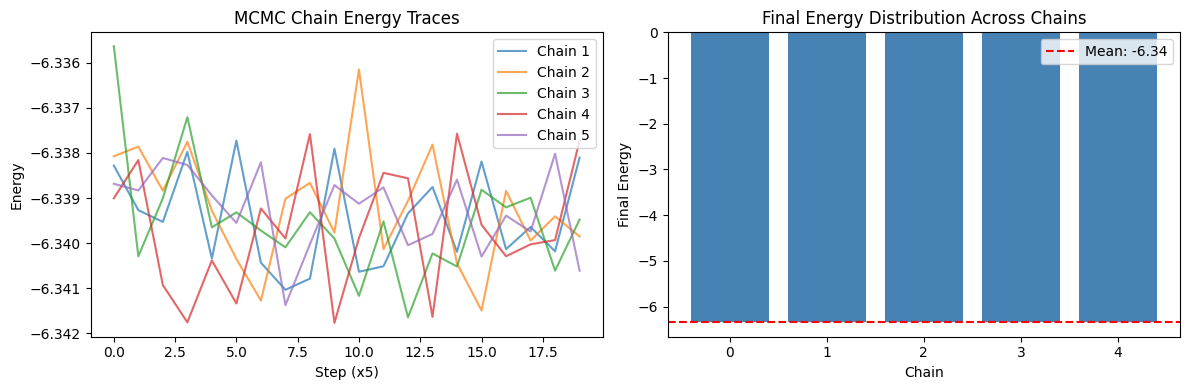


📊 Chain Convergence Summary:
   Mean final energy: -6.3392
   Std final energy: 0.0011
   Ground truth energy: -6.3340
   Gap (chains - real): -0.0051


In [31]:
# MCMC Chain Diagnostics (fixed for dict batches)

import torch
import numpy as np
import matplotlib.pyplot as plt

print("🔗 MCMC Chain Diagnostics...")

# Get test batch (dict format)
test_batch = next(iter(val_loader))
u_real = test_batch['u_zt'].to(device)       # [B, Z, T, F]
h_zt = test_batch['h_zt'].to(device)         # [B, Z, T, D]
zone_mask = test_batch['zone_mask'].to(device)  # [B, Z]

B, Z, T, F = u_real.shape
print(f"📦 Batch: {B} samples, {Z} zones, {T} timesteps, {F} features")

# Run multiple chains
n_chains = 5
n_steps = 100
chain_energies = []

# Model must be in train mode for GRU backward
model.train()

for chain_idx in range(n_chains):
    # Random initialization in logit space
    z = torch.randn(B, Z, T, F, device=device) * 0.1 + sampler_infer.prior_logit
    z = z.requires_grad_(True)

    chain_energy = []

    for step in range(n_steps):
        # Relaxation
        u = torch.sigmoid(z)

        # Apply zone mask
        mask = zone_mask.view(B, Z, 1, 1).float()
        u_masked = u * mask

        # Compute energy
        energy = model(u_masked, h_zt, zone_mask).sum()

        # Gradient
        grad_z = torch.autograd.grad(energy, z)[0]

        # Normalize gradient
        g_std = grad_z.std()
        if g_std > 1e-9:
            grad_z = grad_z / g_std

        # Prior drift
        prior_drift = 3.0 * (z.detach() - sampler_infer.prior_logit)

        # Langevin update
        step_size = 0.02
        noise = torch.randn_like(z) * 0.1

        z = z - step_size * grad_z - step_size * prior_drift + noise
        z = z * mask  # Zero out padded zones
        z = z.detach().requires_grad_(True)

        if step % 5 == 0:
            with torch.no_grad():
                e = model(torch.sigmoid(z) * mask, h_zt, zone_mask).mean().item()
            chain_energy.append(e)

    chain_energies.append(chain_energy)
    print(f"  Chain {chain_idx+1}: Final E = {chain_energy[-1]:.4f}")

# Plot chain convergence
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, energies in enumerate(chain_energies):
    axes[0].plot(energies, label=f'Chain {i+1}', alpha=0.7)
axes[0].set_xlabel('Step (x5)')
axes[0].set_ylabel('Energy')
axes[0].set_title('MCMC Chain Energy Traces')
axes[0].legend()

# Final energy distribution
final_energies = [e[-1] for e in chain_energies]
axes[1].bar(range(n_chains), final_energies, color='steelblue')
axes[1].axhline(y=np.mean(final_energies), color='red', linestyle='--',
                label=f'Mean: {np.mean(final_energies):.2f}')
axes[1].set_xlabel('Chain')
axes[1].set_ylabel('Final Energy')
axes[1].set_title('Final Energy Distribution Across Chains')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'temporal_mcmc_diagnostics.png'), dpi=150)
plt.show()

# Ground truth energy for comparison
with torch.no_grad():
    E_real = model(u_real, h_zt, zone_mask).mean().item()

print(f"\n📊 Chain Convergence Summary:")
print(f"   Mean final energy: {np.mean(final_energies):.4f}")
print(f"   Std final energy: {np.std(final_energies):.4f}")
print(f"   Ground truth energy: {E_real:.4f}")
print(f"   Gap (chains - real): {np.mean(final_energies) - E_real:.4f}")

In [32]:
def solve_lp_with_commitment(scenario_path, u_binary=None, binary_dict=None):
    """
    Solve LP dispatch with fixed binary commitments.
    Updated to support full set of binaries: Thermal, DR, Storage, Import.

    Args:
        scenario_path: Path to scenario file
        u_binary: Flattened binary vector (Legacy/Fallback)
        binary_dict: Dict with structured binaries (Recommended)
                     Format: { "u_thermal": {zone: [0,1...]}, "dr_active": ... }

    Returns:
        result: Dict with objective, solve time, feasibility status, and dispatch detail
    """
    import warnings
    import logging
    import time
    from pathlib import Path
    from pyomo.environ import SolverFactory, value
    from pyomo.core import TransformationFactory

    # Suppress Pyomo warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        logging.getLogger('pyomo').setLevel(logging.ERROR)

        try:
            # 1. Load scenario & Build Model
            from src.milp.scenario_loader import load_scenario_data
            from src.milp.model import build_uc_model # Assurez-vous que l'import est bon

            data = load_scenario_data(Path(scenario_path))
            model = build_uc_model(data, enable_duals=False)

            fixed_count = 0

            # 2. Fix Binary Variables (From Dictionary)
            if binary_dict is not None:
                print(f"    Fixing binaries from structured dict...")

                # Mapping: Clé du dictionnaire -> Nom de la variable dans le modèle Pyomo
                # (On teste plusieurs noms potentiels pour être robuste)
                var_mapping = {
                    "u_thermal": ["u_thermal"],
                    "v_thermal_startup": ["v_thermal_startup", "v_startup"],
                    "u_nuclear": ["u_nuclear"],
                    "v_nuclear_startup": ["v_nuclear_startup"],

                    # Nouveaux ajouts
                    "dr_active": ["u_dr", "dr_active"],
                    "battery_charge_mode": ["u_bat_charge", "u_battery_charge", "battery_mode"],
                    "pumped_charge_mode": ["u_pumped_charge", "u_pmp_charge", "pumped_mode"],
                    "import_mode": ["u_import", "u_net_import", "import_mode"]
                }

                # Itération sur les Zones et le Temps
                for zone in model.Z:
                    zone_str = str(zone)

                    for t in model.T:
                        t_int = int(t)

                        # Pour chaque type de variable binaire
                        for dict_key, model_attr_candidates in var_mapping.items():

                            # Si cette variable existe dans le dictionnaire d'entrée pour cette zone
                            if dict_key in binary_dict and zone_str in binary_dict[dict_key]:

                                # On cherche l'attribut correspondant dans le modèle Pyomo
                                target_var = None
                                for attr in model_attr_candidates:
                                    if hasattr(model, attr):
                                        target_var = getattr(model, attr)
                                        break

                                # Si trouvé, on fixe la valeur
                                if target_var is not None:
                                    # Vérifier si la variable existe pour cet index (zone, t)
                                    # Certaines variables (ex: import) peuvent ne pas être indicées par zone
                                    if (zone, t) in target_var:
                                        val = binary_dict[dict_key][zone_str][t_int]
                                        target_var[zone, t].fix(float(val))
                                        fixed_count += 1
                                    elif t in target_var: # Cas variables globales (non-zonales)
                                        # Attention : si global, on ne fixe qu'une fois (ou on écrase)
                                        val = binary_dict[dict_key][zone_str][t_int]
                                        target_var[t].fix(float(val))
                                        fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from structured dict")

            # 3. Fix Binary Variables (From Flattened Vector - Fallback)
            elif u_binary is not None:
                print(f"    Fixing binaries from flattened vector (Legacy mode)...")
                # ... (Votre code legacy, conservé au cas où, mais risqué avec 6 features) ...
                u_np = u_binary.cpu().numpy().flatten() if hasattr(u_binary, 'cpu') else u_binary.flatten()

                n_zones = len(data.zones)
                n_timesteps = len(data.periods)

                # Try to infer structure - assume 4 binaries per zone per timestep
                # [u_thermal, v_thermal_startup, u_nuclear, v_nuclear_startup]
                expected_size = n_zones * n_timesteps * 4

                if len(u_np) == expected_size:
                    idx = 0
                    for t in range(n_timesteps):
                        for z_idx, zone in enumerate(data.zones):
                            if idx + 3 < len(u_np):
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                model.v_thermal_startup[zone, t].fix(float(u_np[idx + 1]))
                                model.u_nuclear[zone, t].fix(float(u_np[idx + 2]))
                                model.v_nuclear_startup[zone, t].fix(float(u_np[idx + 3]))
                                idx += 4
                                fixed_count += 4
                else:
                    print(f"    ⚠ Size mismatch: got {len(u_np)}, expected {expected_size}")
                    print(f"    Attempting best-effort mapping...")

                    n_bins_per_type = len(u_np) // 2
                    for t in range(min(n_timesteps, len(u_np) // n_zones)):
                        for z_idx, zone in enumerate(data.zones):
                            idx = t * n_zones + z_idx
                            if idx < n_bins_per_type:
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                fixed_count += 1
                            if idx + n_bins_per_type < len(u_np):
                                model.u_nuclear[zone, t].fix(float(u_np[idx + n_bins_per_type]))
                                fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from flattened vector")


            # 4. Solve LP
            # Relax any remaining integer variables (safety net)
            TransformationFactory("core.relax_integer_vars").apply_to(model)

            solver = SolverFactory("highs")
            start = time.time()
            results = solver.solve(model, tee=False, load_solutions=False)
            solve_time = time.time() - start

            # 5. Extract Results
            termination = results.solver.termination_condition
            status = results.solver.status

            feasible = False
            objective = float('inf')
            detail = None

            if termination in ['optimal', 'feasible']:
                model.solutions.load_from(results)
                objective = value(model.obj)
                feasible = True

                # Extraction simplifiée des détails pour log/visu
                periods = list(model.T)
                zones = [str(z) for z in model.Z]

                # Helper safe value extraction
                def get_val(comp, idx, default=0.0):
                    if hasattr(model, comp) and idx in getattr(model, comp):
                        return float(value(getattr(model, comp)[idx]))
                    return default

                detail = {
                    "time_steps": [int(t) for t in periods],
                    "zones": zones,
                    "demand": {z: [get_val('demand', (z,t)) for t in periods] for z in zones},
                    "thermal": {z: [get_val('p_thermal', (z,t)) for t in periods] for z in zones},
                    "nuclear": {z: [get_val('p_nuclear', (z,t)) for t in periods] for z in zones},
                    "battery_charge": {z: [get_val('b_charge', (z,t)) for t in periods] for z in zones},
                    "battery_discharge": {z: [get_val('b_discharge', (z,t)) for t in periods] for z in zones},
                    "dr_shed": {z: [get_val('dr_shed', (z,t)) for t in periods] for z in zones},
                    "unserved": {z: [get_val('unserved', (z,t)) for t in periods] for z in zones},
                    "net_import": [get_val('net_import', t) for t in periods],
                }

            return {
                'objective': objective,
                'solve_time': solve_time,
                'status': str(status),
                'termination': str(termination),
                'feasible': feasible,
                'fixed_count': fixed_count,
                'detail': detail,
            }

        except Exception as e:
            import traceback
            # print(f"    Error details: {traceback.format_exc()}")
            return {
                'objective': float('inf'),
                'solve_time': 0.0,
                'status': 'error',
                'termination': str(e),
                'feasible': False,
                'fixed_count': 0,
                'detail': None,
            }

In [34]:
# Configuration for multi-candidate evaluation (fixed for dict batches)
K_CANDIDATES = 10  # Number of candidates to generate per scenario
N_SCENARIOS_TO_EVAL = 50  # Number of scenarios to fully evaluate

print("=" * 80)
print("MULTI-CANDIDATE GENERATION & EVALUATION")
print("=" * 80)
print(f"Configuration:")
print(f"  - K candidates per scenario: {K_CANDIDATES}")
print(f"  - Scenarios for full LP evaluation: {N_SCENARIOS_TO_EVAL}")
print(f"  - Langevin sampler steps: {sampler_infer.num_steps}")
print("=" * 80)

# Get validation batch (dict format)
val_batch = next(iter(val_loader))
u_pos = val_batch['u_zt'].to(CONFIG['device'])       # [B, Z, T, F]
h_zt = val_batch['h_zt'].to(CONFIG['device'])        # [B, Z, T, D]
zone_mask = val_batch['zone_mask'].to(CONFIG['device'])  # [B, Z]
scenario_ids = val_batch.get('scenario_ids', [f"scenario_{i:05d}" for i in range(len(u_pos))])

B, Z, T, F = u_pos.shape

# Limit to N_SCENARIOS_TO_EVAL
n_eval = min(N_SCENARIOS_TO_EVAL, B)

print(f"\n✓ Loaded {B} scenarios from validation batch")
print(f"  Shape: [B={B}, Z={Z}, T={T}, F={F}]")
print(f"  Evaluating first {n_eval} scenarios")

# Generate K candidates for each scenario
print(f"\n🎲 Generating {K_CANDIDATES} candidates per scenario...")

model.train()  # Required for cuDNN GRU backward

all_candidates = []  # List of [K, Z, T, F] per scenario
all_energies = []    # List of [K] energies per scenario

for i in range(n_eval):
    # Extract single scenario
    h_i = h_zt[i:i+1]          # [1, Z, T, D]
    mask_i = zone_mask[i:i+1]  # [1, Z]

    candidates_i = []
    energies_i = []

    for k in range(K_CANDIDATES):
        # Sample one candidate
        u_sample = sampler_infer.sample(h_i, mask_i)  # [1, Z, T, F]

        # Compute energy
        with torch.no_grad():
            E = model(u_sample, h_i, mask_i).item()

        candidates_i.append(u_sample[0].cpu())  # [Z, T, F]
        energies_i.append(E)

    # Stack candidates
    candidates_i = torch.stack(candidates_i, dim=0)  # [K, Z, T, F]
    energies_i = torch.tensor(energies_i)            # [K]

    all_candidates.append(candidates_i)
    all_energies.append(energies_i)

    if (i + 1) % 10 == 0:
        print(f"  Generated candidates for {i+1}/{n_eval} scenarios")

print(f"\n✓ Generated {K_CANDIDATES} candidates for {n_eval} scenarios")

# Analyze energy distribution
print(f"\n📊 Energy Distribution Analysis:")
for i in range(min(5, n_eval)):
    E = all_energies[i]
    print(f"  Scenario {i}: E_min={E.min():.4f}, E_mean={E.mean():.4f}, E_max={E.max():.4f}")

# Select best candidate per scenario (lowest energy)
best_candidates = []
best_energies = []

for i in range(n_eval):
    best_idx = all_energies[i].argmin()
    best_candidates.append(all_candidates[i][best_idx])  # [Z, T, F]
    best_energies.append(all_energies[i][best_idx].item())

print(f"\n✓ Selected best candidate per scenario")
print(f"  Mean best energy: {np.mean(best_energies):.4f}")
print(f"  Std best energy: {np.std(best_energies):.4f}")

MULTI-CANDIDATE GENERATION & EVALUATION
Configuration:
  - K candidates per scenario: 10
  - Scenarios for full LP evaluation: 50
  - Langevin sampler steps: 100

✓ Loaded 128 scenarios from validation batch
  Shape: [B=128, Z=109, T=24, F=7]
  Evaluating first 50 scenarios

🎲 Generating 10 candidates per scenario...
  Generated candidates for 10/50 scenarios
  Generated candidates for 20/50 scenarios
  Generated candidates for 30/50 scenarios
  Generated candidates for 40/50 scenarios
  Generated candidates for 50/50 scenarios

✓ Generated 10 candidates for 50 scenarios

📊 Energy Distribution Analysis:
  Scenario 0: E_min=-6.3581, E_mean=-6.3349, E_max=-6.3105
  Scenario 1: E_min=-6.3443, E_mean=-6.3365, E_max=-6.3272
  Scenario 2: E_min=-6.3547, E_mean=-6.3396, E_max=-6.3282
  Scenario 3: E_min=-6.3467, E_mean=-6.3394, E_max=-6.3283
  Scenario 4: E_min=-6.3619, E_mean=-6.3354, E_max=-6.3151

✓ Selected best candidate per scenario
  Mean best energy: -6.3554
  Std best energy: 0.0087


In [35]:
import numpy as np
import torch
import json
from pathlib import Path

# --- Helper Functions ---

def load_true_oracle_binaries_dict(scenario_id: str, eval_dir: Path):
    """
    Load true binary variables from complete MILP solution JSON.
    Adapted for structure where variables are under the 'detail' key.
    """
    import json

    json_path = eval_dir / f"{scenario_id}.json"

    if not json_path.exists():
        return None

    with open(json_path, 'r') as f:
        solution = json.load(f)

    # Dictionnaire de résultat
    binaries = {}

    # 1. CIBLAGE
    source_data = solution.get("detail", solution)

    # 2. MAPPING
    key_mapping = {
        "dr_active": ["dr_active"],
        "battery_charge_mode": ["battery_charge_mode"],
        "pumped_charge_mode": ["pumped_charge_mode"],
        "import_mode": ["import_mode"],
        "u_thermal": ["u_thermal", "thermal_commitment", "thermal"],
        "v_thermal_startup": ["v_thermal_startup", "thermal_startup"],
        "u_nuclear": ["u_nuclear", "nuclear_commitment", "nuclear"],
        "v_nuclear_startup": ["v_nuclear_startup", "nuclear_startup"],
    }

    # 3. EXTRACTION
    found_any = False
    for target_key, candidate_keys in key_mapping.items():
        for key in candidate_keys:
            if key in source_data:
                binaries[target_key] = source_data[key]
                found_any = True
                break

    return binaries

def convert_langevin_to_milp_binaries(langevin_vector, data):
    """
    Convert Langevin sampled binaries to MILP format (Robust to 6 or 7 features).
    """
    if torch.is_tensor(langevin_vector):
        u_np = langevin_vector.cpu().numpy().squeeze()
    else:
        u_np = np.array(langevin_vector).squeeze()

    n_zones = len(data.zones)
    n_timesteps = len(data.periods)

    total_elements = len(u_np)
    if total_elements == 0: return None
    n_features = total_elements // (n_zones * n_timesteps)

    if total_elements % (n_zones * n_timesteps) != 0:
        print(f"    ✗ Shape Mismatch: {total_elements} not divisible by {n_zones}x{n_timesteps}")
        return None

    try:
        u_reshaped = u_np.reshape(n_timesteps, n_zones, n_features)
    except:
        return None

    milp_binaries = {
        "dr_active": {}, "battery_charge_mode": {}, "pumped_charge_mode": {},
        "u_thermal": {}, "v_thermal_startup": {}, "import_mode": {}
    }

    if n_features == 7:
        # Legacy
        dr_active = u_reshaped[:, :, 4]
        battery_mode = u_reshaped[:, :, 0]
        pumped_mode = u_reshaped[:, :, 2]
        thermal_commitment = u_reshaped[:, :, 6]
        import_mode = np.zeros_like(thermal_commitment)
    elif n_features == 6:
        # New Format
        dr_active = u_reshaped[:, :, 0]
        battery_mode = u_reshaped[:, :, 1]
        pumped_mode = u_reshaped[:, :, 2]
        thermal_commitment = u_reshaped[:, :, 3]
        import_mode = u_reshaped[:, :, 5]
    else:
        print(f"    ✗ Unknown feature count: {n_features}")
        return None

    # Compute Derived Startup
    thermal_startup = np.zeros_like(thermal_commitment)
    thermal_startup[0, :] = thermal_commitment[0, :]
    diff = thermal_commitment[1:, :] - thermal_commitment[:-1, :]
    thermal_startup[1:, :] = (diff > 0.1).astype(float)

    for z_idx, zone in enumerate(data.zones):
        zone_str = str(zone)
        def clean(arr): return arr[:, z_idx].round().astype(int).tolist()

        milp_binaries["dr_active"][zone_str] = clean(dr_active)
        milp_binaries["battery_charge_mode"][zone_str] = clean(battery_mode)
        milp_binaries["pumped_charge_mode"][zone_str] = clean(pumped_mode)
        milp_binaries["u_thermal"][zone_str] = clean(thermal_commitment)
        milp_binaries["v_thermal_startup"][zone_str] = clean(thermal_startup)
        milp_binaries["import_mode"][zone_str] = clean(import_mode)

    return milp_binaries

def align_binary_dict_like_oracle(langevin_dict, oracle_dict, *, strict=True):
    """
    Force langevin_dict to have EXACTLY the same structure as oracle_dict:
    - same variable keys
    - same zones keys for zone-level variables
    - same length T for each series
    - import_mode uses {"values": [T]}
    """
    out = {}
    # zone-level vars: all keys except import_mode
    for k, v in oracle_dict.items():
        if k == "import_mode":
            T = len(oracle_dict["import_mode"]["values"])
            lv = langevin_dict.get("import_mode", {}).get("values", None)
            if lv is None:
                if strict:
                    raise KeyError("Langevin dict missing import_mode.values")
                lv = [0]*T
            # trim/pad
            lv = list(lv)[:T] + [lv[-1] if len(lv)>0 else 0]*(max(0, T-len(lv)))
            out["import_mode"] = {"values": [int(x) for x in lv]}
        else:
            # zone dict
            out_k = {}
            for zone, arr_oracle in v.items():
                T = len(arr_oracle)
                lv_zone = langevin_dict.get(k, {}).get(str(zone), None)
                if lv_zone is None:
                    if strict:
                        raise KeyError(f"Langevin dict missing {k}[{zone}]")
                    lv_zone = [0]*T
                lv_zone = list(lv_zone)[:T] + [lv_zone[-1] if len(lv_zone)>0 else 0]*(max(0, T-len(lv_zone)))
                out_k[str(zone)] = [int(x) for x in lv_zone]
            out[k] = out_k

    return out



In [37]:
# DIAGNOSTIC CELL: Compare EBM output structure vs Oracle structure

import torch
import numpy as np
from pathlib import Path

# Get one scenario to analyze
i = 0
sid = scenario_ids[i]
print(f"Analyzing scenario: {sid}")
print("=" * 60)

# 1. Load Oracle binaries
oracle_bins = load_true_oracle_binaries_dict(sid, SCENARIO_DIR_EVAL)
print("\n📋 ORACLE STRUCTURE:")
for key, val in oracle_bins.items():
    if isinstance(val, dict):
        if 'values' in val:
            print(f"  {key}: global, T={len(val['values'])}")
        else:
            zones = list(val.keys())
            T = len(list(val.values())[0]) if zones else 0
            print(f"  {key}: {len(zones)} zones, T={T}")
            print(f"    Zone names: {zones[:5]}...")  # First 5
    else:
        print(f"  {key}: {type(val)}")

# 2. EBM output structure
u_best = best_candidates[i].detach().cpu()
print(f"\n📋 EBM OUTPUT STRUCTURE:")
print(f"  Shape: {u_best.shape}  # [Z, T, F]")
print(f"  Z={u_best.shape[0]}, T={u_best.shape[1]}, F={u_best.shape[2]}")

# 3. Zone names from scenario data
from src.milp.scenario_loader import load_scenario_data
scen_path = Path(CONFIG['scenarios_dir']) / f"{sid}.json"
s_data = load_scenario_data(scen_path)
ebm_zone_names = list(s_data.zones)
print(f"\n📋 ZONE NAME COMPARISON:")
print(f"  EBM zones (from scenario): {ebm_zone_names[:5]}...")
print(f"  Oracle zones (from u_thermal): {list(oracle_bins.get('u_thermal', {}).keys())[:5]}...")

# 4. Check zone mask
valid_zones = zone_mask[i].cpu().numpy()
n_valid = valid_zones.sum()
print(f"\n📋 ZONE MASK:")
print(f"  Valid zones: {int(n_valid)} / {len(valid_zones)}")

# 5. Feature mapping check
print(f"\n📋 FEATURE MAPPING (EBM index -> LP var):")
feature_names = [
    'battery_charge',      # 0
    'battery_discharge',   # 1
    'pumped_charge',       # 2
    'pumped_discharge',    # 3
    'demand_response',     # 4
    'nuclear',             # 5
    'thermal',             # 6
    'hydro_release',       # 7
    'unserved',            # 8
    'overgen_spill',       # 9
]
oracle_keys = list(oracle_bins.keys())
print(f"  EBM features: {feature_names}")
print(f"  Oracle keys: {oracle_keys}")

# 6. Value comparison for one zone
if oracle_bins and 'u_thermal' in oracle_bins:
    oracle_zone = list(oracle_bins['u_thermal'].keys())[0]
    oracle_thermal = oracle_bins['u_thermal'][oracle_zone]

    # Find matching zone in EBM
    if oracle_zone in ebm_zone_names:
        z_idx = ebm_zone_names.index(oracle_zone)
        ebm_thermal = (u_best[z_idx, :, 6].numpy() > 0.5).astype(int).tolist()

        print(f"\n📋 VALUE COMPARISON (zone={oracle_zone}, u_thermal):")
        print(f"  Oracle:  {oracle_thermal[:12]}...")
        print(f"  EBM:     {ebm_thermal[:12]}...")

        matches = sum(1 for o, e in zip(oracle_thermal, ebm_thermal) if o == e)
        print(f"  Match rate: {matches}/{len(oracle_thermal)} = {100*matches/len(oracle_thermal):.1f}%")

Analyzing scenario: scenario_02608


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [38]:
def convert_ebm_to_lp_binaries(u_best, zone_mask_i, zone_names, Z, T, F):
    """
    Convert EBM output [Z, T, F] to LP binary dict.
    Includes ALL needed binaries:
    - Core commitments: u_thermal, u_nuclear, dr_active, battery_charge_mode, pumped_charge_mode
    - Derived: v_thermal_startup (computed from u_thermal)
    - Global: import_mode (set to 0 if not available)
    """
    # EBM feature index -> LP variable name
    feature_to_lp = {
        6: 'u_thermal',
        5: 'u_nuclear',
        4: 'dr_active',
        0: 'battery_charge_mode',
        2: 'pumped_charge_mode',
    }

    l_bins = {lp_var: {} for lp_var in feature_to_lp.values()}
    l_bins['v_thermal_startup'] = {}  # Will be computed
    l_bins['import_mode'] = {'values': [0] * T}  # Global, default to 0

    valid_zones = zone_mask_i.cpu().numpy()
    u_np = u_best.detach().cpu().numpy()

    for z_idx in range(Z):
        if valid_zones[z_idx] == 0:
            continue
        zone_name = zone_names[z_idx] if z_idx < len(zone_names) else str(z_idx)

        # Extract and binarize each feature
        for f_idx, lp_var in feature_to_lp.items():
            if f_idx < F:
                values = (u_np[z_idx, :, f_idx] > 0.5).astype(int).tolist()
                l_bins[lp_var][zone_name] = values

        # Compute v_thermal_startup from u_thermal
        # startup[t] = 1 if u[t]=1 and u[t-1]=0, else 0
        u_thermal = l_bins['u_thermal'][zone_name]
        v_startup = [0] * T
        v_startup[0] = u_thermal[0]  # First timestep: startup if committed
        for t in range(1, T):
            v_startup[t] = 1 if (u_thermal[t] == 1 and u_thermal[t-1] == 0) else 0
        l_bins['v_thermal_startup'][zone_name] = v_startup

    return l_bins


RUNNING FINAL EVALUATION & PLOTTING
Processing scenario_02608...    Fixing binaries from structured dict...
    Fixed 1080 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 1080 binary variables from structured dict
 Gap: INFEAS
Processing scenario_01602...    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
 Gap: INFEAS
Processing scenario_00394...    Fixing binaries from structured dict...
    Fixed 2952 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 2952 binary variables from structured dict
 Gap: INFEAS
Processing scenario_00978...    Fixing binaries from structured dict...
    Fixed 5688 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 5688 binary variables from structured dict
 Gap: +17.20%
Processing scenario_02

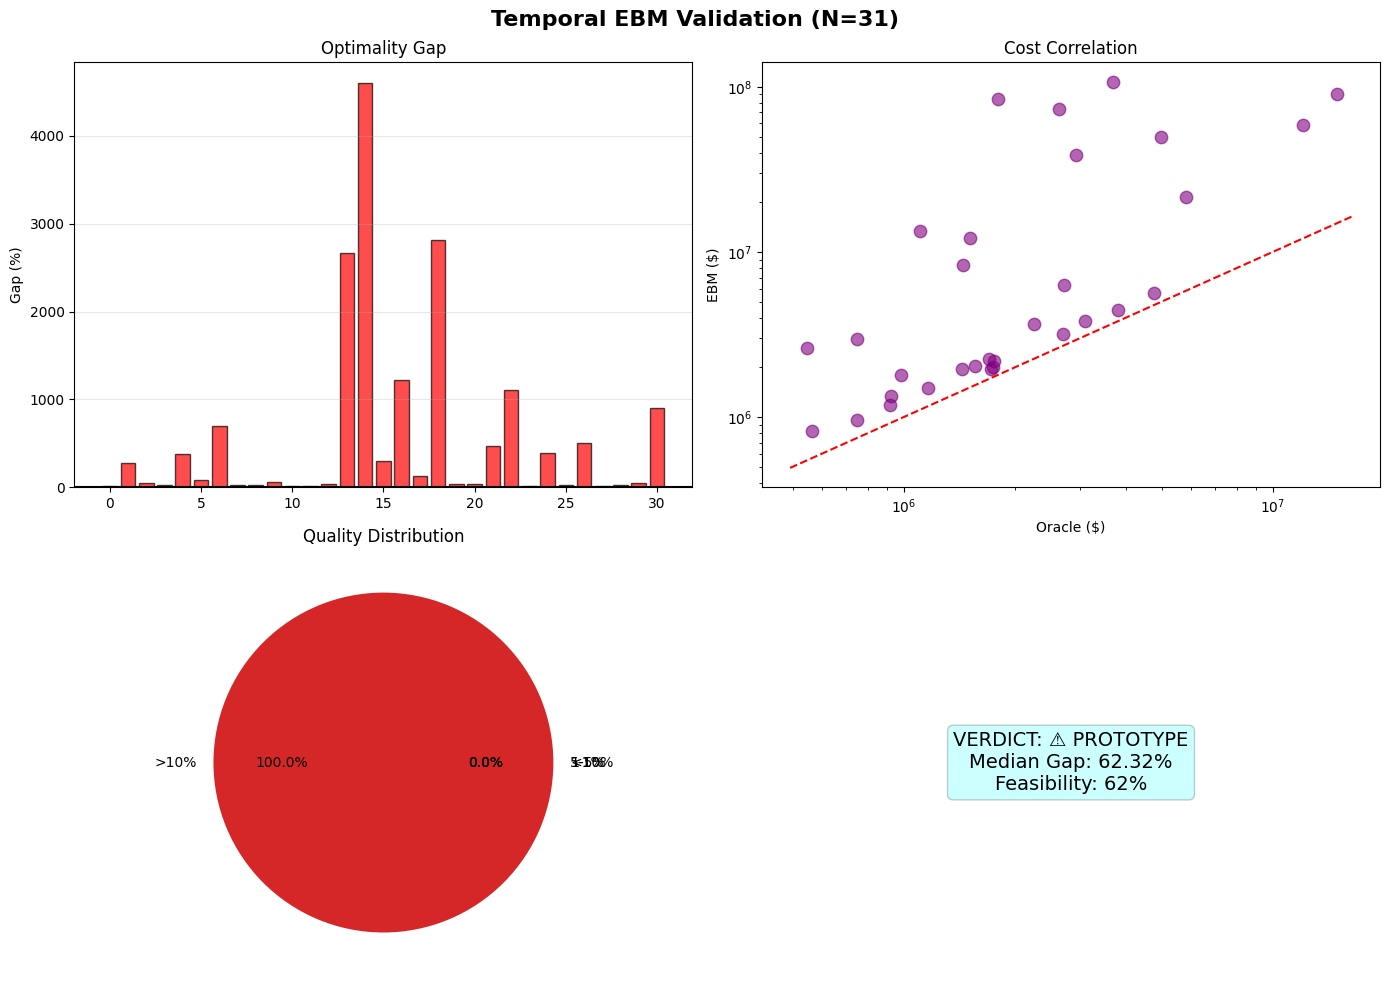


✅ ⚠️ PROTOTYPE | Median: 62.32% | Feasibility: 62%


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json
import os
from pathlib import Path

# ==============================================================================
# 1. HELPER FUNCTIONS
# ==============================================================================

def load_true_oracle_binaries_dict(scenario_id: str, eval_dir: Path):
    """Load true binary variables from complete MILP solution JSON."""
    json_path = eval_dir / f"{scenario_id}.json"
    if not json_path.exists(): return None

    with open(json_path, 'r') as f: solution = json.load(f)

    binaries = {}
    source = solution.get("detail", solution)

    key_mapping = {
        "dr_active": ["dr_active"], "battery_charge_mode": ["battery_charge_mode"],
        "pumped_charge_mode": ["pumped_charge_mode"], "import_mode": ["import_mode"],
        "u_thermal": ["u_thermal", "thermal_commitment", "thermal"],
        "v_thermal_startup": ["v_thermal_startup", "thermal_startup"],
        "u_nuclear": ["u_nuclear"], "v_nuclear_startup": ["v_nuclear_startup"]
    }
    for k, opts in key_mapping.items():
        for opt in opts:
            if opt in source: binaries[k] = source[opt]; break
    return binaries


def convert_ebm_to_lp_binaries(u_best, zone_mask_i, zone_names, Z, T, F):
    """
    Convert EBM output [Z, T, F] to LP binary dict with ALL needed binaries.
    """
    feature_to_lp = {
        6: 'u_thermal',
        5: 'u_nuclear',
        4: 'dr_active',
        0: 'battery_charge_mode',
        2: 'pumped_charge_mode',
    }

    l_bins = {lp_var: {} for lp_var in feature_to_lp.values()}
    l_bins['v_thermal_startup'] = {}
    l_bins['import_mode'] = {'values': [0] * T}  # Global, default 0

    valid_zones = zone_mask_i.cpu().numpy()
    u_np = u_best.detach().cpu().numpy()

    for z_idx in range(Z):
        if valid_zones[z_idx] == 0:
            continue
        zone_name = zone_names[z_idx] if z_idx < len(zone_names) else str(z_idx)

        for f_idx, lp_var in feature_to_lp.items():
            if f_idx < F:
                values = (u_np[z_idx, :, f_idx] > 0.5).astype(int).tolist()
                l_bins[lp_var][zone_name] = values

        # Compute v_thermal_startup from u_thermal
        u_thermal = l_bins['u_thermal'][zone_name]
        v_startup = [0] * T
        v_startup[0] = u_thermal[0]
        for t in range(1, T):
            v_startup[t] = 1 if (u_thermal[t] == 1 and u_thermal[t-1] == 0) else 0
        l_bins['v_thermal_startup'][zone_name] = v_startup

    return l_bins


# ==============================================================================
# 2. EVALUATION LOOP (FIXED FOR DICT BATCHES)
# ==============================================================================
print("\n" + "=" * 80)
print("RUNNING FINAL EVALUATION & PLOTTING")
print("=" * 80)

EVAL_DIR = Path(CONFIG['output_dir']).parent / 'scenarios_v1_filtered' / 'reports'
lp_results = []

# Uses: best_candidates, scenario_ids, zone_mask, n_eval, Z, T, F from multi-candidate cell

for i in range(n_eval):
    sid = scenario_ids[i] if i < len(scenario_ids) else f"scenario_{i:05d}"

    # Locate scenario file
    scen_path = None
    for ext in ['.json', '.pkl']:
        p = Path(CONFIG['scenarios_dir']) / f"{sid}{ext}"
        if p.exists(): scen_path = p; break

    if scen_path is None:
        print(f"⚠ File not found: {sid}")
        continue

    print(f"Processing {sid}...", end="")

    # 1. Oracle
    oracle_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    oracle_bins = load_true_oracle_binaries_dict(sid, EVAL_DIR)
    if oracle_bins:
        oracle_res = solve_lp_with_commitment(scen_path, binary_dict=oracle_bins)

    # 2. EBM/Langevin
    langevin_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    try:
        from src.milp.scenario_loader import load_scenario_data
        s_data = load_scenario_data(scen_path)
        zone_names = list(s_data.zones) if hasattr(s_data, 'zones') else [f"z{z}" for z in range(Z)]

        u_best = best_candidates[i]
        l_bins = convert_ebm_to_lp_binaries(u_best, zone_mask[i], zone_names, Z, T, F)
        langevin_res = solve_lp_with_commitment(scen_path, binary_dict=l_bins)
    except Exception as e:
        print(f" Err: {e}", end="")

    lp_results.append({
        'scenario_id': sid,
        'oracle': oracle_res,
        'langevin': langevin_res
    })

    gap_str = "N/A"
    if oracle_res['feasible'] and langevin_res['feasible']:
        gap = 100 * (langevin_res['objective'] - oracle_res['objective']) / (oracle_res['objective'] + 1e-9)
        gap_str = f"{gap:+.2f}%"
    elif oracle_res['feasible'] and not langevin_res['feasible']:
        gap_str = "INFEAS"
    print(f" Gap: {gap_str}")


# ==============================================================================
# 3. ANALYSIS & PLOTTING
# ==============================================================================
print("\n" + "-" * 40)
print("GENERATING VERDICT PLOTS...")

if len(lp_results) == 0:
    print("⚠ No LP results. Check scenario paths.")
else:
    data = [{
        'scenario_id': r['scenario_id'],
        'oracle_feasible': r['oracle']['feasible'],
        'oracle_cost': r['oracle']['objective'],
        'langevin_feasible': r['langevin']['feasible'],
        'langevin_cost': r['langevin']['objective'],
    } for r in lp_results]

    df = pd.DataFrame(data)
    print(f"\n📊 Summary: {len(df)} scenarios")
    print(f"   Oracle feasible: {df['oracle_feasible'].sum()}")
    print(f"   Langevin feasible: {df['langevin_feasible'].sum()}")

    valid_df = df[df['oracle_feasible'] & df['langevin_feasible']].copy()

    if len(valid_df) > 0:
        valid_df['gap_pct'] = 100 * (valid_df['langevin_cost'] - valid_df['oracle_cost']) / valid_df['oracle_cost']
        valid_df['short_id'] = valid_df['scenario_id'].apply(lambda x: str(x).split('_')[-1])

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f"Temporal EBM Validation (N={len(valid_df)})", fontsize=16, fontweight='bold')

        # A. Bar Chart
        ax = axes[0,0]
        colors = ['green' if g < 1 else 'lime' if g < 5 else 'orange' if g < 10 else 'red' for g in valid_df['gap_pct']]
        ax.bar(range(len(valid_df)), valid_df['gap_pct'], color=colors, edgecolor='black', alpha=0.7)
        ax.axhline(0, color='black'); ax.set_ylabel("Gap (%)"); ax.set_title("Optimality Gap")
        ax.grid(True, axis='y', alpha=0.3)

        # B. Scatter
        ax = axes[0,1]
        ax.scatter(valid_df['oracle_cost'], valid_df['langevin_cost'], s=80, c='purple', alpha=0.6)
        m1, m2 = valid_df['oracle_cost'].min()*0.9, valid_df['oracle_cost'].max()*1.1
        ax.plot([m1, m2], [m1, m2], 'r--')
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel("Oracle ($)"); ax.set_ylabel("EBM ($)"); ax.set_title("Cost Correlation")

        # C. Pie
        ax = axes[1,0]
        sizes = [(valid_df['gap_pct'] < 1).sum(), ((valid_df['gap_pct'] >= 1) & (valid_df['gap_pct'] < 5)).sum(),
                 ((valid_df['gap_pct'] >= 5) & (valid_df['gap_pct'] < 10)).sum(), (valid_df['gap_pct'] >= 10).sum()]
        if sum(sizes) > 0:
            ax.pie(sizes, labels=['<1%', '1-5%', '5-10%', '>10%'], colors=['#2ca02c','#98df8a','#ff7f0e','#d62728'], autopct='%1.1f%%')
            ax.set_title("Quality Distribution")

        # D. Verdict
        ax = axes[1,1]; ax.axis('off')
        med = valid_df['gap_pct'].median()
        verdict = "🚀 SOTA" if med < 1 else "✅ INDUSTRIAL" if med < 5 else "⚠️ PROTOTYPE"
        feas_rate = 100 * len(valid_df) / len(df)
        ax.text(0.5, 0.5, f"VERDICT: {verdict}\nMedian Gap: {med:.2f}%\nFeasibility: {feas_rate:.0f}%",
                ha='center', va='center', fontsize=14, bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.2))

        plt.tight_layout()
        plt.savefig(os.path.join(CONFIG['output_dir'], 'temporal_ebm_validation.png'), dpi=150)
        plt.show()
        print(f"\n✅ {verdict} | Median: {med:.2f}% | Feasibility: {feas_rate:.0f}%")
    else:
        print("⚠ No valid comparisons (all infeasible).")

## 18. Visualize MILP vs Langevin Dispatch Comparison